In [1]:
import pandas as pd
import numpy as np

RSEED = 42
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')

from tqdm import tqdm

import tensorflow as tf
tf.random.set_seed(RSEED)
from tensorflow.keras.layers import Concatenate

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score  


from survive import SurvivalData
from survive import KaplanMeier



import sys
sys.path.append('/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/AE')
import models, run_models

sys.path.append('/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/helper_functions')
import helpers, clustering_helpers


import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)





2023-12-21 13:23:01.170072: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In  models file
Using TensorFlow backend
In run_models python file


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


### Read the datasets 

In [3]:
time_series_2d = np.load('preprocessing/representations/time_series_2d_scaled.npy')
time_series_3d = np.load('preprocessing/representations/time_series_3d_scaled.npy')

static = pd.read_csv('preprocessing/representations/static_eq.csv')
time_series_2d_df = pd.read_csv('preprocessing/representations/time_series_2d_scaled_df.csv')
time_series_3d_df = pd.read_csv('preprocessing/representations/time_series_3d.csv')


folder_sepsis = 'sepsis3_queries/data'
sepsis3 = pd.read_csv(f'{folder_sepsis}/sepsis-df-3.csv')

In [4]:
time_series_2d.shape

(5784, 24, 47)

In [5]:
time_series_3d.shape

(5784, 24, 47)

In [6]:
time_series_2d_df = time_series_2d_df.set_index('icustay_id')

time_series_2d_df.shape

(5784, 47)

In [7]:
print('static shape before dropping empty values', static.shape)

static = static.loc[:, static.gt(0).mean() >= .1]
print('static shape after dropping empty values', static.shape)


static shape before dropping empty values (5784, 52)
static shape after dropping empty values (5784, 32)


In [8]:
static.columns

Index(['icustay_id', 'vent', 'F', 'M', 'adults', 'seniors', 'race_white',
       'race_other', 'gcs_13_15', 'gcs_9_12', 'gcs_<8',
       'congestive_heart_failure', 'cardiac_arrhythmias', 'hypertension',
       'other_neurological', 'chronic_pulmonary', 'diabetes_uncomplicated',
       'hypothyroidism', 'renal_failure', 'liver_disease', 'coagulopathy',
       'fluid_electrolyte', 'alcohol_abuse', 'depression', 'diabetes',
       'circulatory', 'circulatory_infectious_congenital', 'nervous_and_sense',
       'endocrinal_nutritional', 'neoplasms', 'blood_and_blood_forming',
       'mental'],
      dtype='object')

In [9]:
static = static.set_index('icustay_id')

#sepsis3
static = static[['vent', 'F', 'M', 'adults', 'seniors', 'race_white', 'race_other',
    'gcs_13_15', 'gcs_9_12', 'gcs_<8', 'congestive_heart_failure',
    'cardiac_arrhythmias', 'hypertension', 'other_neurological',
    'chronic_pulmonary',  'hypothyroidism',
    'renal_failure', 'liver_disease', 'coagulopathy', 'fluid_electrolyte',
    'alcohol_abuse', 'depression', 'diabetes', 'circulatory',
    'circulatory_infectious_congenital', 'nervous_and_sense',
    'endocrinal_nutritional', 'neoplasms', 'blood_and_blood_forming',
    'mental']]
    
static.shape

(5784, 30)

In [10]:

time_series_3d = time_series_3d.astype(np.float32)
static = static.astype(float)


## Load models

In [11]:
static = static.fillna(0)

In [12]:
## load the encoded representations

path = f'results_EQ/saved_models' 
latent_ts, latent_st, latent_mm = helpers.load_encoded_spaces(time_series_3d, static, 'latent_4(3)_EQ', path)
#helpers.

  1/181 [..............................] - ETA: 55s

181/181 [==============================] - 1s 2ms/step
STATIC AE SHAPE: (5784, 4)
181/181 [==============================] - 2s 6ms/step
GRU SHAPE: (5784, 8)
181/181 [==============================] - 3s 6ms/step
MM SHAPE: (5784, 10)


## Multiple runs model

In [13]:


# path = f'results_EQ_angus/saved_models_avg' 
# num_runs = 10
# all_encoded_static = []
# all_encoded_time_series = []
# all_encoded_mm = []

# for run in tqdm(range(num_runs), desc="Training Autoencoders"):
#     current_seed = RSEED + run  # Use a different seed for each run
#     tf.random.set_seed(current_seed)
#     np.random.seed(current_seed)
#     print(run, current_seed)

#     latent_ts, latent_st, latent_mm = helpers.load_encoded_spaces(time_series_3d, static, f'latent_avg_{run}', path)
#     all_encoded_static.append(latent_st)
#     all_encoded_time_series.append(latent_ts)
#     all_encoded_mm.append(latent_mm)
    
# # Compute the average of the encoded representations
# average_encoded_static = np.mean(all_encoded_static, axis=0)
# average_encoded_time_series = np.mean(all_encoded_time_series, axis=0)
# average_encoded_mm = np.mean(all_encoded_mm, axis=0)



## Baselines


HDBSCAN
Best Parameters: {'min_cluster_size': 30, 'min_samples': 2}
Best Silhouette Score: -0.06936617
K-PROTOTYPES
HIERARCHICAL


/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` 

CONSENSUS


/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10

optimal k ts:  3
optimal k static:  3


/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10

5


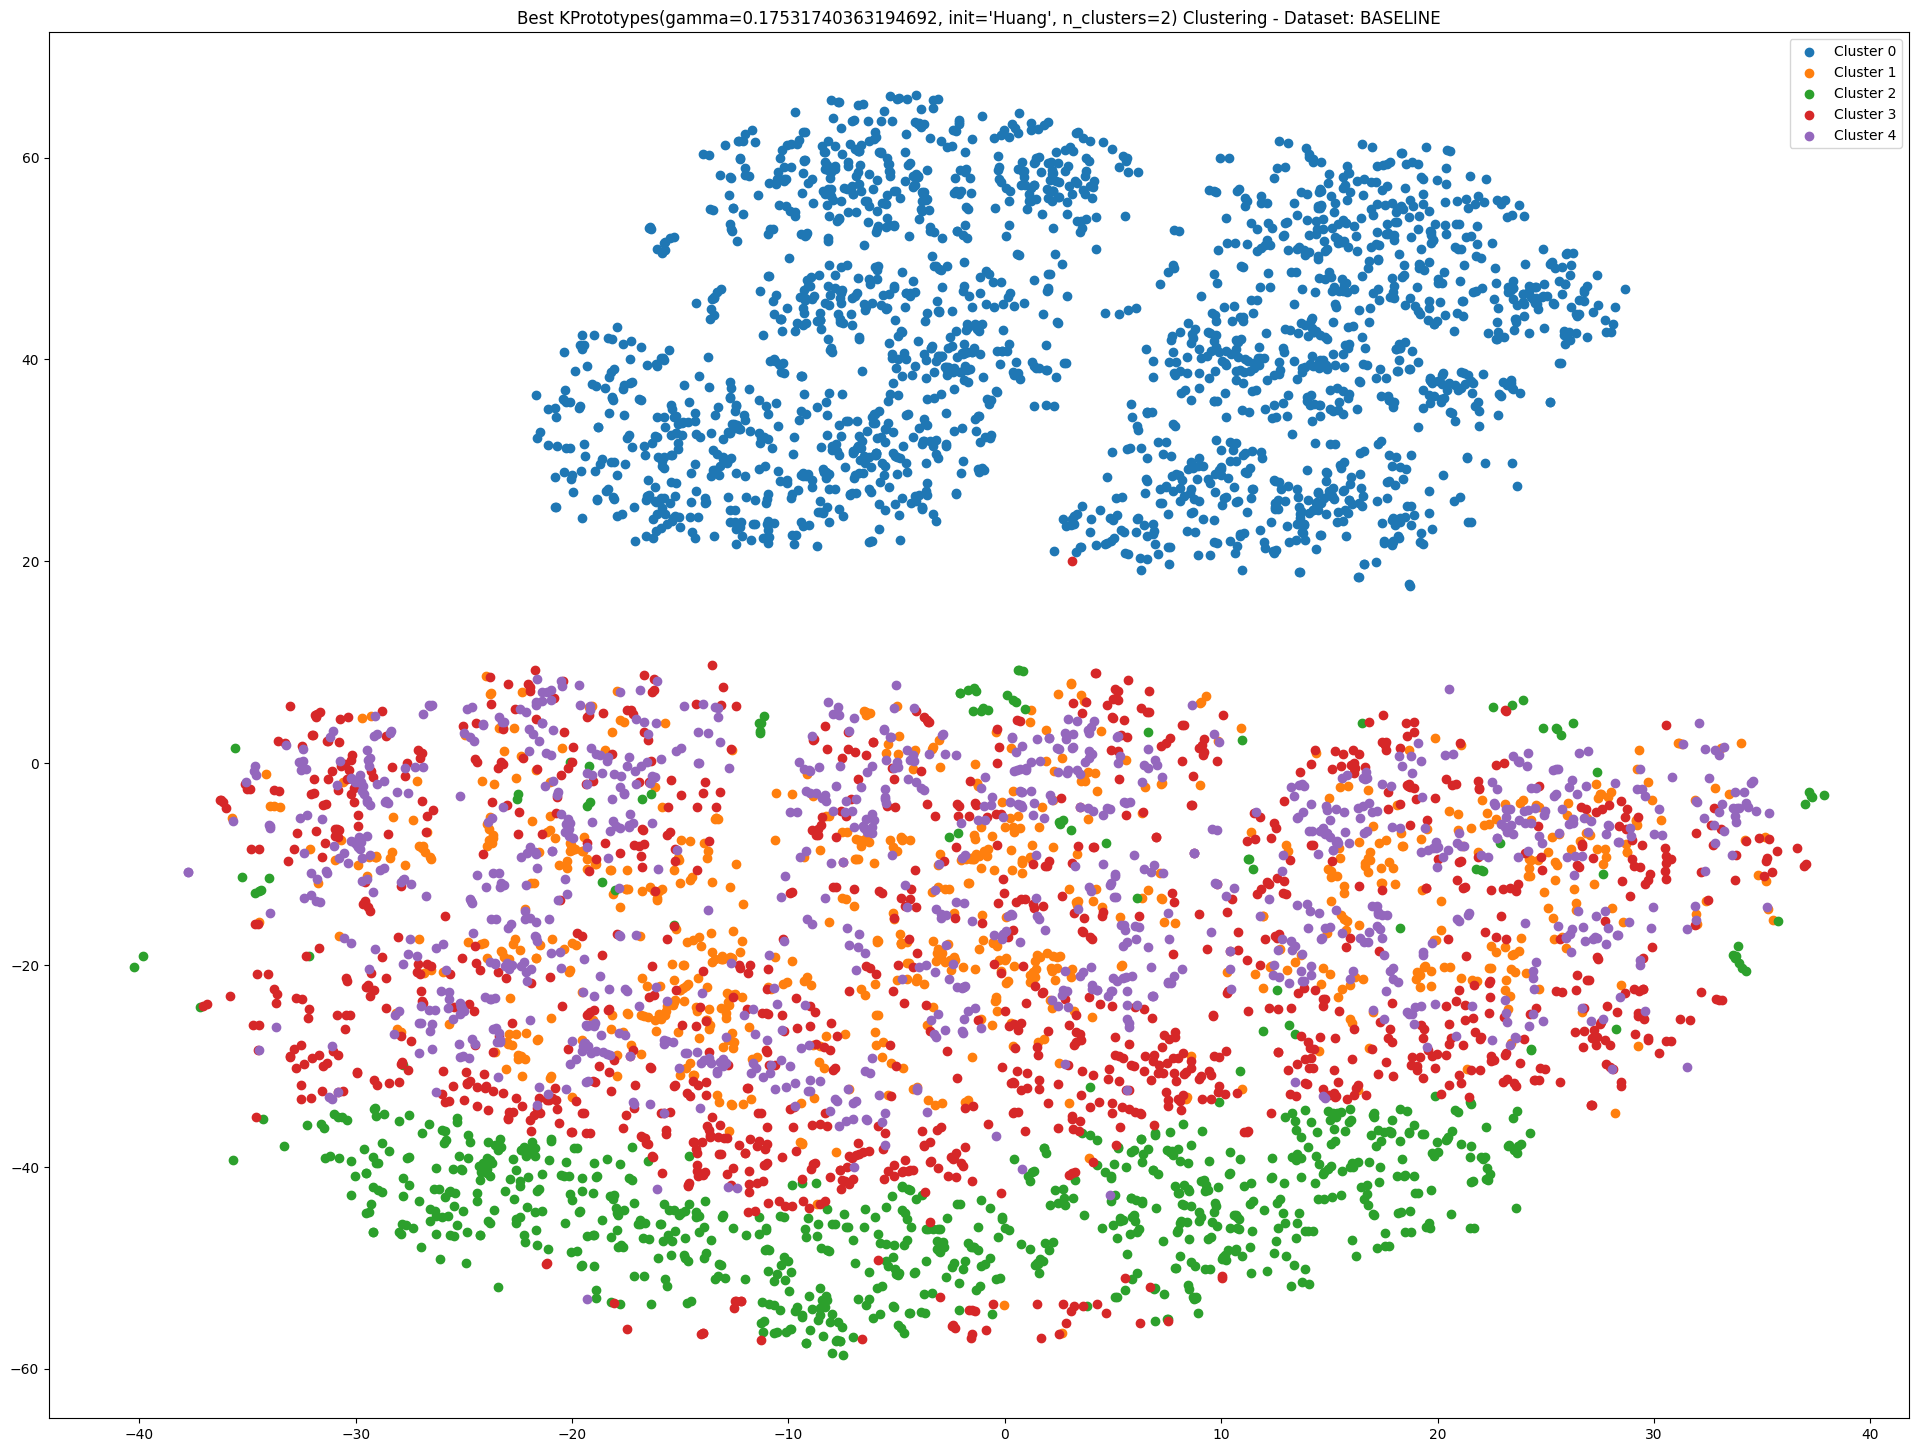

In [14]:
bool_list = [True] * len(static.columns) + [False] * len(time_series_2d_df.columns) 

#time series should be false
best_method_baseline, best_silhouette_score_baseline, best_model_baseline, results_df_baseline, best_labels_baseline = \
    clustering_helpers.compare_clustering_methods_baselines(static, time_series_2d_df, bool_list, 'BASELINE', max_clusters=5)

In [15]:
np.bincount(best_labels_baseline)

array([1950,  762,  843, 1194, 1035])

In [16]:
results_df_baseline

Model  Silhouette Score  Davies-Bouldin Score  \
0       HDBSCAN_gower         -0.069366              1.868086   
1  Hierarchical_gower          0.125075              4.730217   
2        K-Prototypes          0.146022              2.494124   
3           Consensus          0.097245              2.932797   
4        Consensus_ts          0.027066              9.175228   
5    Consensus_static          0.064825              3.149413   

   Calinski-Harabasz Score  
0               706.228964  
1              1437.594258  
2               848.845689  
3               559.315286  
4               184.115450  
5               318.142116

In [16]:
# results_df_baseline

# results_df_baseline.to_csv(f'{path}/metrics/baselines_results.csv')

## Comparison of fusions 

In [17]:
# latent_late_fusion = Concatenate()([latent_ts, latent_st])
# latent_late_fusion = np.array(latent_late_fusion)
# #average_late_fusion = Concatenate()([average_encoded_static, average_encoded_static])
# #average_late_fusion = np.array(average_late_fusion)
# data = [latent_st, latent_ts, latent_mm, latent_late_fusion]
# #average_encoded_static, average_encoded_time_series, average_encoded_mm, average_late_fusion
# #latent_st, latent_ts, latent_mm, latent_late_fusion
# dataset_name = ['st', 'ts', 'mm', 'lf']
# #'st', 'ts', 'mm', 'lf'
# #'encoded_static', 'encoded_time_series', 
# # data = [encoded_mm, encoded_late_fusion]

# results = pd.DataFrame()
# best_labels = pd.DataFrame()
# all_labels = pd.DataFrame()
# for i, y in zip(data, dataset_name):
#     df_results, best_labels_, labels_df, best_model = clustering_helpers.compare_kmeans_hdbscan(i, dataset_name = y,  max_k=100)

#     df_results.index = [y, y, y]

#     y = f'{y}_{best_model}'
#     labels_ = pd.Series(best_labels_, name=y)
#     best_labels = pd.concat([best_labels, labels_], axis=1)
#     all_labels = pd.concat([all_labels, labels_df], axis=1)
    

#     #results = results.append(df_results)
#     results = pd.concat([results, df_results])

In [18]:
import os
path = f'results_EQ' 


# if not os.path.isdir(f"{path}/metrics"):

#     os.makedirs(f"{path}/metrics")

# results.to_csv(f'{path}/metrics/ae_results.csv')
# all_labels.to_csv(f'{path}/metrics/all_labels.csv')

results  = pd.read_csv(f'{path}/metrics/ae_results.csv')
all_labels = pd.read_csv(f'{path}/metrics/all_labels.csv')

In [19]:
all_labels['mm_Agglomerative'].value_counts().sort_index()

0     128
1     243
2     248
3     180
4     566
5      96
6     199
7      94
8     129
9     120
10    558
11    245
12     53
13    176
14    354
15    148
16    132
17     91
18    131
19     72
20    174
21    124
22    245
23     29
24    129
25     45
26    109
27     82
28     45
29     51
30     70
31     34
32    215
33    152
34     66
35     63
36     56
37     37
38     70
39     25
Name: mm_Agglomerative, dtype: int64

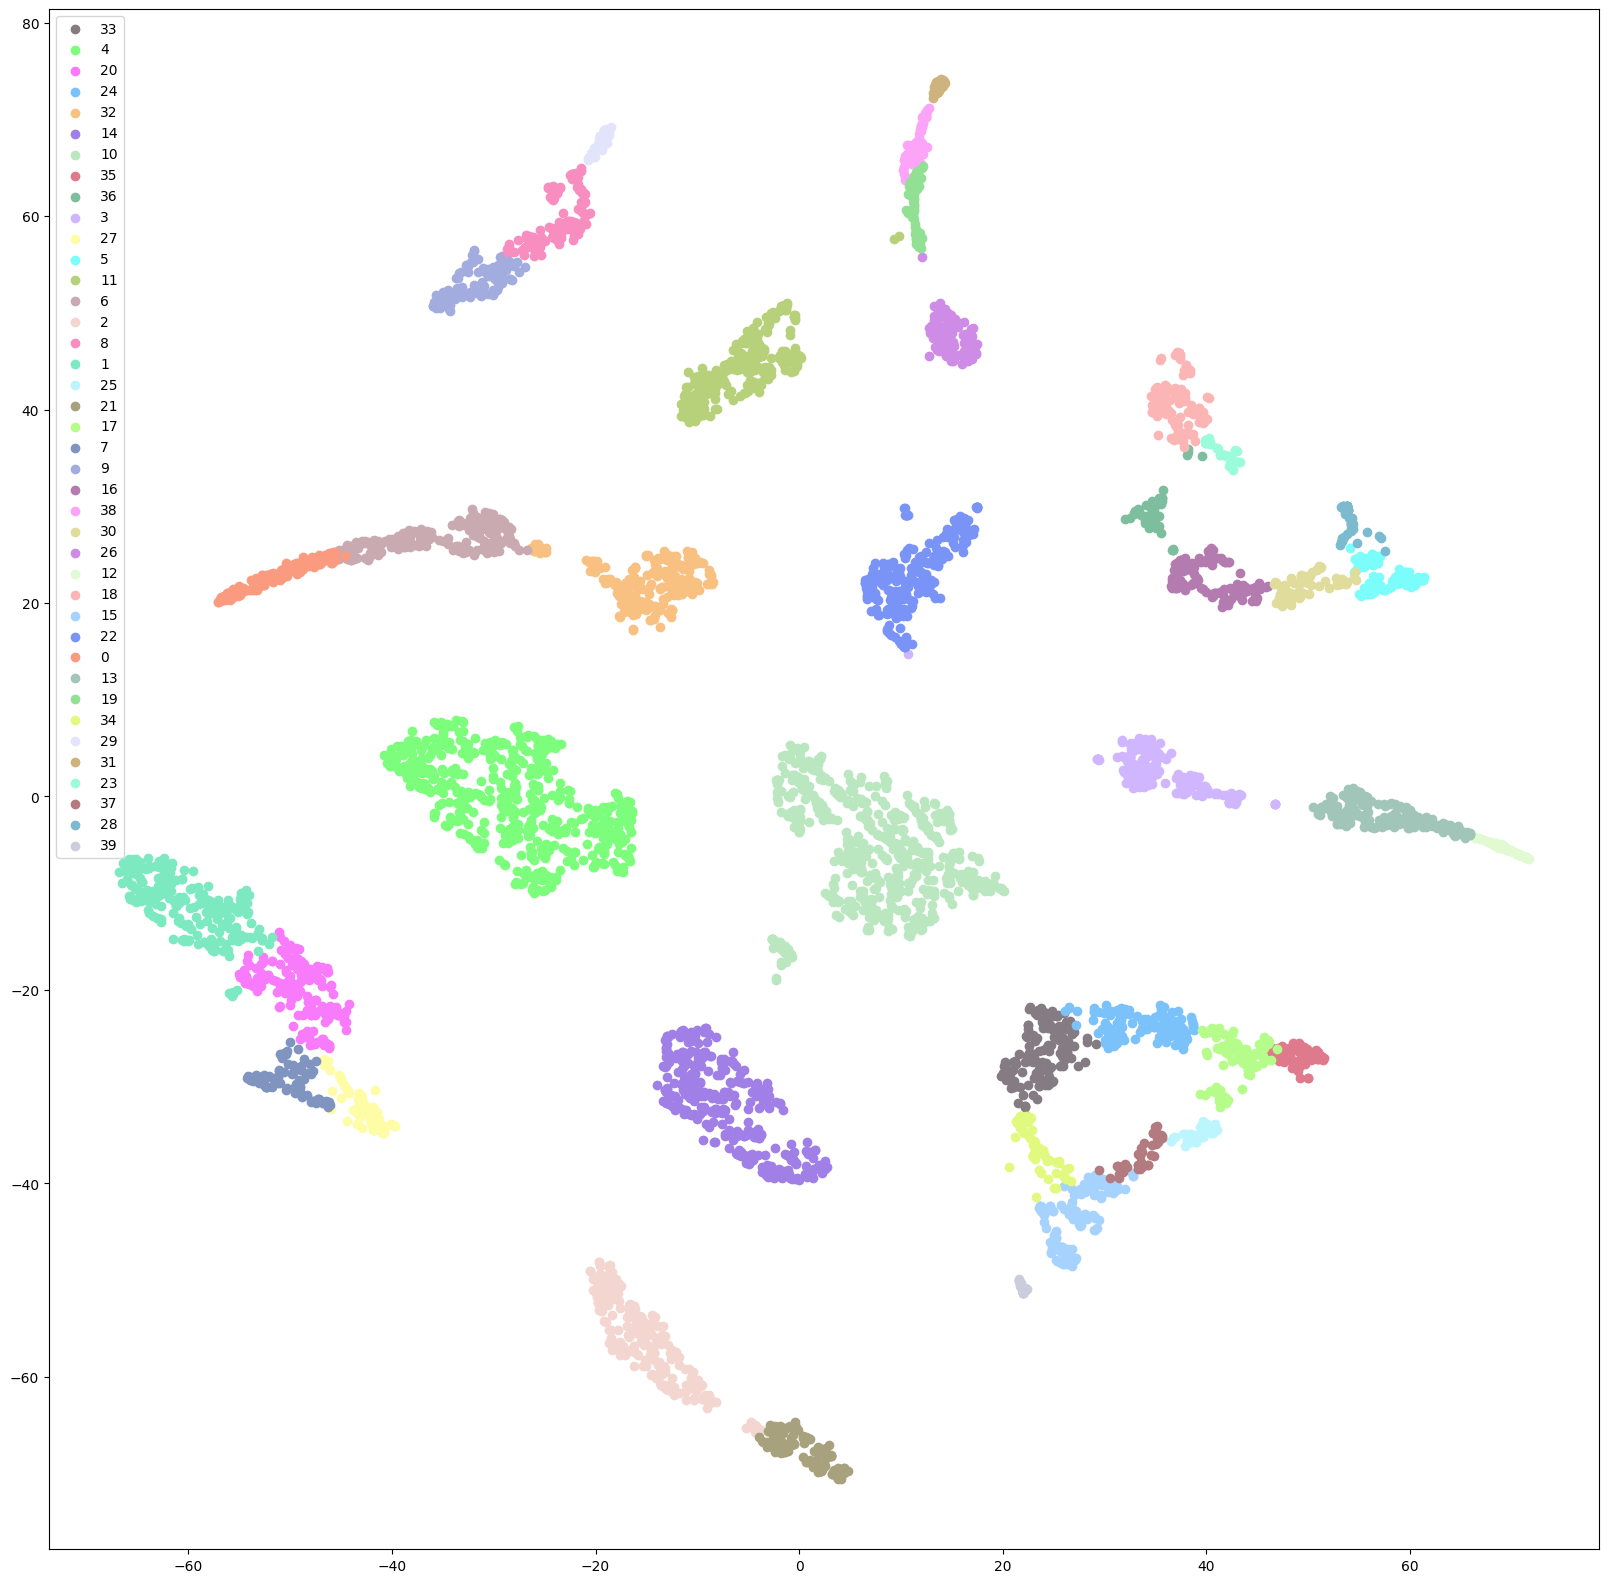

In [20]:
from sklearn.manifold import TSNE
import distinctipy

best_reduced_data = TSNE(n_components=2, random_state=2, perplexity=50).fit_transform(latent_mm) 
plt.figure(figsize=(20, 20))

# Get unique categories and corresponding colors
unique_categories = all_labels['mm_Agglomerative'].unique()
num_categories = len(unique_categories)

# number of colours to generate
N = 40

# generate N visually distinct colours
colors = distinctipy.get_colors(N, pastel_factor=0.9)

# Create a scatter plot for each category
for i, category in enumerate(unique_categories):
    category_mask = all_labels['mm_Agglomerative'] == category
    plt.scatter(best_reduced_data[:,0][category_mask], best_reduced_data[:,1][category_mask], c=[colors[i]], label=category)

# Display the legend
plt.legend()

plt.show()

In [21]:
results

Unnamed: 0          Model  Silhouette Score  Davies-Bouldin Score  \
0          st         KMeans          0.265652              1.180373   
1          st        HDBSCAN          0.218393              2.553022   
2          st  Agglomerative          0.288975              1.333703   
3          ts         KMeans          0.289413              1.466823   
4          ts        HDBSCAN          0.230512              1.478643   
5          ts  Agglomerative          0.462531              1.191482   
6          mm         KMeans          0.483907              0.710744   
7          mm        HDBSCAN          0.401228              1.313601   
8          mm  Agglomerative          0.537424              0.667319   
9          lf         KMeans          0.192021              1.419730   
10         lf        HDBSCAN         -0.075044              2.695108   
11         lf  Agglomerative          0.257910              1.424517   

    Calinski-Harabasz Score  
0               1387.169426  
1               1107.191304  
2               2177.856773  
3               1048.590623  
4                399.085930  
5                584.873520  
6               5941.382243  
7               3380.993399  
8               8602.965823  
9                949.291859  
10               297.313177  
11              1925.881698

In [22]:
# plt.style.use('default')
# # Perform cluster stability analysis using Spectral
# labels_ = ['mm_Agglomerative']
# jaccard_indices_mm = clustering_helpers.cluster_stability(latent_mm, all_labels[labels_][labels_[0]].values, 26, 'agglomerative', num_iterations=100)
# mean_jaccard_mm = np.mean(jaccard_indices_mm)

# labels_ = ['lf_HDBSCAN']
# # Perform cluster stability analysis using KMeans
# jaccard_indices_lf = clustering_helpers.cluster_stability(latent_late_fusion, all_labels[labels_][labels_[0]].values, 3, 'hdbscan', num_iterations=100)
# mean_jaccard_lf = np.mean(jaccard_indices_lf)

# # Plotting ARI and Jaccard Index across the runs
# plt.figure(figsize=(6, 6))
# plt.plot(range(1, len(jaccard_indices_mm) + 1), jaccard_indices_mm, label="Jaccard Index MMAE: {0:.2}".format(mean_jaccard_mm), marker='o')
# plt.plot(range(1, len(jaccard_indices_lf) + 1), jaccard_indices_lf, label="Jaccard Index EFAE: {0:.2}".format(mean_jaccard_lf) , marker='o')
# plt.xlabel("Bootstrap Iteration")
# plt.ylabel("Index Value")
# plt.legend()
# plt.tight_layout()

# plt.show()



## KM

In [23]:
folder_sepsis = 'sepsis3_queries/data'
sepsis3 = pd.read_csv(f'{folder_sepsis}/sepsis-df-3.csv')
#sepsis3 = sepsis3[sepsis3.sepsis_angus == 1]
sepsis3 = sepsis3.set_index('icustay_id')

In [24]:
all_labels.columns

Index(['Unnamed: 0', 'st_KMeans', 'st_HDBSCAN', 'st_Agglomerative',
       'ts_KMeans', 'ts_HDBSCAN', 'ts_Agglomerative', 'mm_KMeans',
       'mm_HDBSCAN', 'mm_Agglomerative', 'lf_KMeans', 'lf_HDBSCAN',
       'lf_Agglomerative'],
      dtype='object')

In [25]:
labels_ = ['mm_Agglomerative']

In [26]:
all_labels.index = sepsis3.index

In [27]:
# labels_ = ['mm_Agglomerative']


# sns.set(style="darkgrid", palette="colorblind", color_codes=True)



# for modality in labels_:
#     kmd = sepsis3.join(all_labels[modality])
#     surv = SurvivalData(time="icu_los", status="mort_icu", group=modality, data=kmd)
#     print(kmd.groupby(modality)['mort_icu'].value_counts())

#     #observed lifetimes of all the individuals in the data. Censored individuals are marked at the end of their lifespan.
#     plt.figure(figsize=(20, 16))
#     surv.plot_lifetimes()
#     plt.title(modality)
#     plt.show()
#     plt.close()

#     #kaplan meier
#     km = KaplanMeier()
#     km.fit(surv)

#     #display(km.summary())
#     # abulates the survival probability estimates and thier 
#     # standard error and confidence intervals for the event times within each group. 
#     # It can be printed to display all the information at once.
#     #print(km.summary)
#     plt.figure(figsize=(20, 16))
#     km.plot()
#     plt.title(modality)
#     plt.show()
#     plt.close()


#     estimate = km.predict([1, 3, 5, 10, 30])
#     # estimated probabiltiies for surviving past a certain time for each group.
#     print(modality)
#     display(estimate)

## Cluster size,  outcome characteristics.

In [28]:
from tableone import TableOne
warnings.filterwarnings("ignore") 

sepsis3temp1 = sepsis3[['hospital_expire_flag', 'thirtyday_expire_flag', 'mort_icu',
       'icu_los', 'hosp_los']]

sepsis3temp1 = (static[['adults', 'seniors']]).join(sepsis3temp1).join(all_labels[labels_])


sepsis3temp1 = sepsis3temp1.rename(columns={'thirtyday_expire_flag':'30 day mortality', 'hospital_expire_flag':'in hospital mortality','mort_icu':'in icu mortality',\
                                            'icu_los':'icu length of stay','hosp_los':'hospital length of stay' })

table1_sepsis3 = TableOne(sepsis3temp1, groupby=labels_, missing=False, tukey_test=True, normal_test=True, pval=True, pval_adjust=True, display_all=True)

print(table1_sepsis3)

                                       Grouped by mm_Agglomerative                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
                                                           Overall            0            1           10           11          12           13           14           15           16           17           18           19            2           20           21           22          23           24          25           26          27          28          29            3          30          31          

In [29]:
from tableone import TableOne
warnings.filterwarnings("ignore") 

sepsis3temp1 = sepsis3[['hospital_expire_flag', 'thirtyday_expire_flag', 'mort_icu',
       'icu_los', 'hosp_los']]

sepsis3temp1 = (static[['adults', 'seniors']]).join(sepsis3temp1).join(all_labels[labels_])


sepsis3temp1 = sepsis3temp1.rename(columns={'thirtyday_expire_flag':'30 day mortality', 'hospital_expire_flag':'in hospital mortality','mort_icu':'in icu mortality',\
                                            'icu_los':'icu length of stay','hosp_los':'hospital length of stay' })

table1_sepsis3 = TableOne(sepsis3temp1, groupby=labels_, missing=False, tukey_test=True, normal_test=True, pval=True, pval_adjust=True, display_all=True)

print(table1_sepsis3)


                                       Grouped by mm_Agglomerative                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
                                                           Overall            0            1           10           11          12           13           14           15           16           17           18           19            2           20           21           22          23           24          25           26          27          28          29            3          30          31          

In [30]:
#print(table1_sepsis3.tabulate(tablefmt = "latex"))


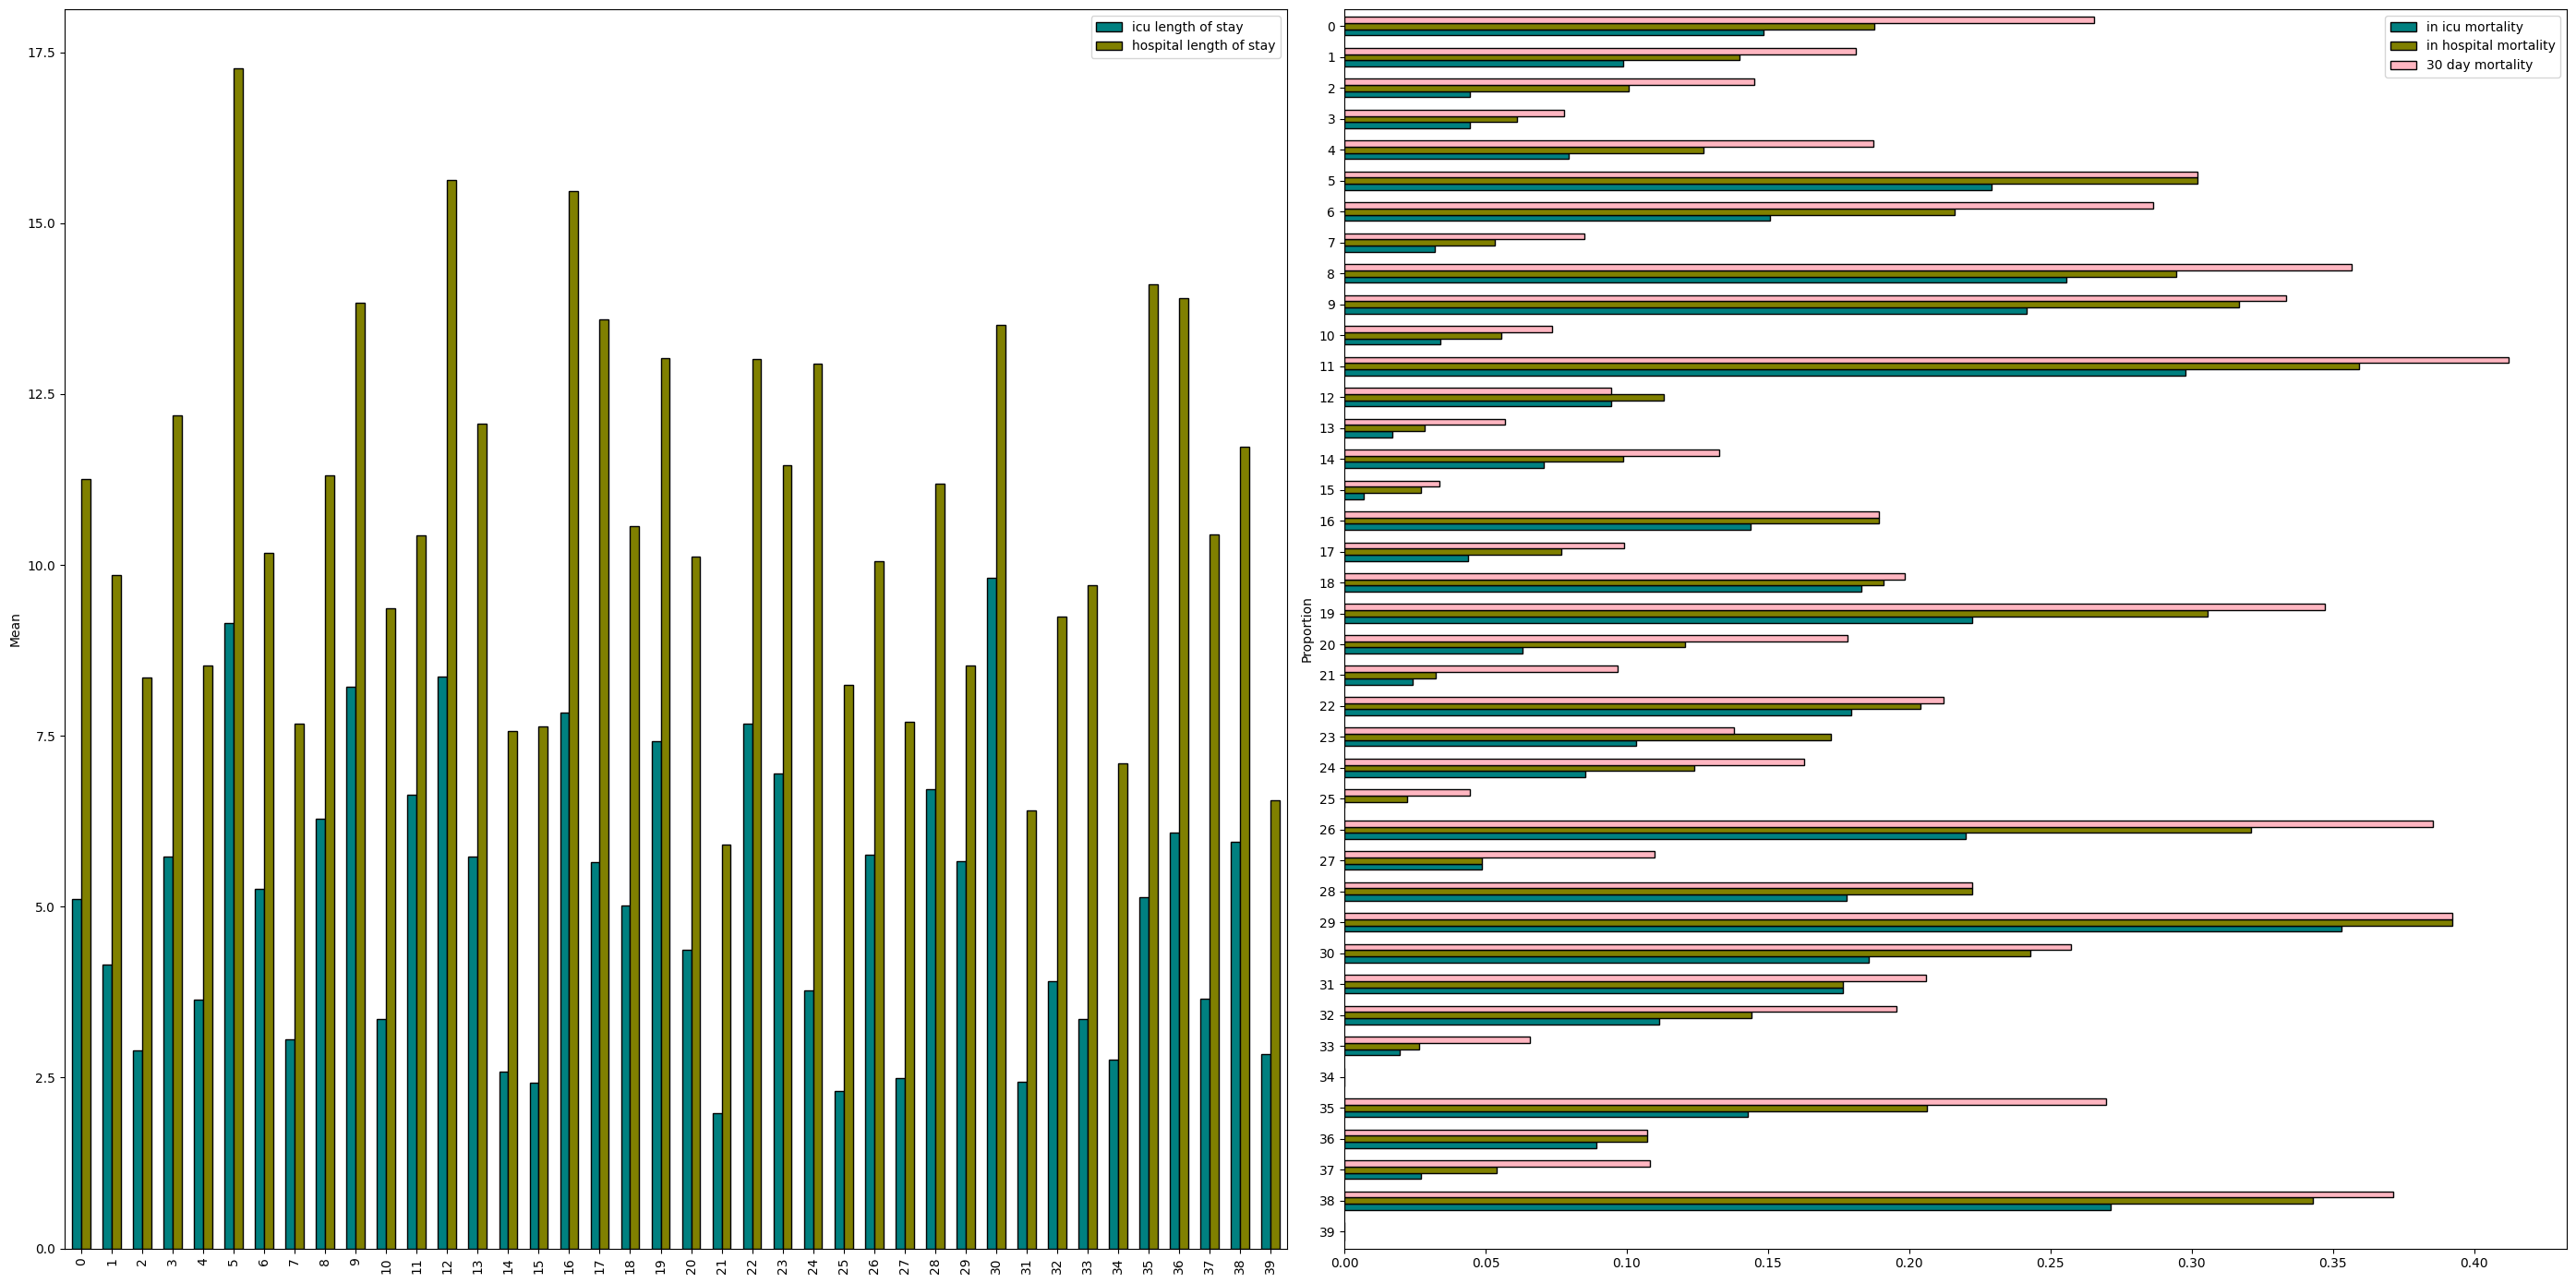

In [31]:
custom_colors = ['teal', 'olive', 'lightpink']

clustering_helpers.grouped_bar_plots(sepsis3temp1, [['icu length of stay', 'hospital length of stay'], ['in icu mortality', 'in hospital mortality','30 day mortality' ]], 
                  labels_[0], custom_colors, bar_width=0.6)


In [32]:
table = TableOne(sepsis3temp1, groupby= labels_, pval = True,pval_adjust='bonferroni', smd=False,
                  htest_name=True, display_all=True)
table

Grouped by mm_Agglomerative                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
                                                           Missing      Overall            0            1           10           11          12           13           14           15           16           17           18           19            2           20           21           22          23           24          25           26          27          28          29            3          30          31           32           33          34           35           36          37           38          39            4            5            6           7            8            9 P-Value (adjusted)                                       Test
n                                                                          5784          128          243          558          245          53          176          354          148          132           91          131           72          248          174          124          245          29          129          45          109          82          45          51          180          70          34          215          152          66           63           56          37           70          25          566           96          199          94          129          120                                                              
adults, n (%)                      0.0                           0  3407 (58.9)  128 (100.0)  243 (100.0)     36 (6.5)  245 (100.0)                  3 (1.7)  354 (100.0)      1 (0.7)      1 (0.8)                 27 (20.6)   72 (100.0)  248 (100.0)  174 (100.0)  124 (100.0)     14 (5.7)     1 (3.4)                           109 (100.0)  82 (100.0)              51 (100.0)    25 (13.9)              34 (100.0)  215 (100.0)      4 (2.6)     4 (6.1)                  9 (16.1)               70 (100.0)  25 (100.0)  566 (100.0)               199 (100.0)  94 (100.0)  129 (100.0)  120 (100.0)             <0.001                                Chi-squared
                                   1.0                              2377 (41.1)                             522 (93.5)               53 (100.0)   173 (98.3)                147 (99.3)   131 (99.2)   91 (100.0)   104 (79.4)                                                       231 (94.3)   28 (96.6)  129 (100.0)  45 (100.0)                           45 (100.0)               155 (86.1)  70 (100.0)                            148 (97.4)   62 (93.9)   63 (100.0)    47 (83.9)  37 (100.0)                                         96 (100.0)                                                                                                                 
seniors, n (%)                     1.0                           0  3253 (56.2)  128 (100.0)  243 (100.0)               245 (100.0)                            353 (99.7)                                                       72 (100.0)  248 (100.0)  174 (100.0)  124 (100.0)                                                     107 (98.2)  82 (100.0)              51 (100.0)                           34 (100.0)   214 (99.5)                                                                  70 (100.0)              566 (100.0)               199 (100.0)  94 (100.0)  129 (100.0)  120 (100.0)             <0.001                                Chi-squared
                                   0.0                              2531 (43.8)                            558 (100.0)               53 (10

In [33]:
# table1_1 = table1_sepsis3.tableone.T.droplevel(0).reset_index().replace('Overall', -1)
# table1_1 = table1_1.replace('P-Value (adjusted)', 182)
# table1_1['index'] = table1_1['index'].astype(int)

# table1_1 = table1_1.sort_values(by='index')

# table1_1 = table1_1.replace( 182, 'P-Value (adjusted)')
# table1_1 = table1_1.replace(-1, 'Overall')
# table1_1 = table1_1.set_index('index')
# table1_1

### Diagnoses at admission and end of hospital stay

In [34]:
# diagnoses_at_admission = sepsis3[[
#     'diagnosis'
# ]]

# diagnoses_at_admission = diagnoses_at_admission.join(all_labels[labels_])

# diagnoses_at_admission.groupby('mm_Agglomerative').value_counts().reset_index(name='count').groupby('mm_Agglomerative').head(6).set_index('mm_Agglomerative')


In [35]:
# diagnoses = pd.read_csv(f'{folder_sepsis}/diagnoses.csv')
# diagnoses = diagnoses[diagnoses.hadm_id.isin(sepsis3.hadm_id)]
# sepsis3 = sepsis3.join(all_labels[labels_])
# sepsis3 = sepsis3.reset_index().set_index('hadm_id')
# diagnoses = diagnoses.set_index('hadm_id')
# diagnoses = diagnoses.join(sepsis3)
# sepsis3 = sepsis3.reset_index().set_index('icustay_id')

# diagnoses = diagnoses.reset_index().set_index('icustay_id')
# diagnoses = diagnoses[['icd9_code', 'icd9_title', 'mm_Agglomerative']]
# # Mapping dictionary with ranges
# icd9_mapping = {
#     'Infectious and Parasitic Diseases': ('001', '139'),
#     'Neoplasms': ('140', '239'),
#     'Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders': ('240', '279'),
#     'Diseases of the Blood and Blood-Forming Organs': ('280', '289'),
#     'Mental Disorders': ('290', '319'),
#     'Diseases of the Nervous System and Sense Organs': ('320', '389'),
#     'Diseases of the Circulatory System': ('390', '459'),
#     'Diseases of the Respiratory System': ('460', '519'),
#     'Diseases of the Digestive System': ('520', '579'),
#     'Diseases of the Genitourinary System': ('580', '629'),
#     'Complications of Pregnancy, Childbirth, and the Puerperium': ('630', '679'),
#     'Diseases of the Skin and Subcutaneous Tissue': ('680', '709'),
#     'Diseases of the Musculoskeletal System and Connective Tissue': ('710', '739'),
#     'Congenital Anomalies': ('740', '759'),
#     'Certain Conditions Originating in the Perinatal Period': ('760', '779'),
#     'Symptoms, Signs, and Ill-Defined Conditions': ('780', '799'),
#     'Injury and Poisoning': ('800', '999'),
#     'External Causes of Injury and Supplemental Classification': ('E00', 'V99')
# }
# diagnoses['upper_hierarchy'] = diagnoses['icd9_code'].str[:3]
# # Check if icd9_code falls within the specified range for each category
# for category, (lower, upper) in icd9_mapping.items():
#     diagnoses[category] = diagnoses['upper_hierarchy'].between(lower, upper)

# diagnoses['Combinedicd9'] = diagnoses.apply(lambda row: ' '.join(row.iloc[4:].index[row.iloc[4:]]), axis=1)
# diagnoses = diagnoses[['icd9_code',	'icd9_title',	'mm_Agglomerative',	'upper_hierarchy', 'Combinedicd9']]
# freq_diagnoses = diagnoses.groupby('icustay_id').Combinedicd9.value_counts().reset_index(name='count').groupby('icustay_id').head(1).set_index('icustay_id')
# freq_diagnoses = freq_diagnoses.join(diagnoses['mm_Agglomerative'])
# freq_diagnoses =freq_diagnoses.drop_duplicates()
# freq_diagnoses.drop('count', axis=1).groupby('mm_Agglomerative').value_counts().reset_index(name='count').groupby('mm_Agglomerative').head(2).set_index('mm_Agglomerative')


In [36]:
# custom_colors = ['green', 'orange']


# grouped_bar_plots(sepsis3, [['sofa'], ['sirs'], ['qsofa']], labels_[0], custom_colors)


In [37]:
# custom_colors = ['darkkhaki', 'darksalmon', 'cornflowerblue']

# grouped_bar_plots(sepsis3, [ ['sirs', 'sofa', 'qsofa']], 
#                   labels_[0], custom_colors, bar_width=0.6)

In [38]:
# sepsis3.groupby(labels_)['sirs', 'sofa', 'qsofa'].mean().append(pd.Series(sepsis3[['sirs', 'sofa', 'qsofa']].mean(), name='overall'))

## Vitals - Labs - Interventions

*Respiratory Parameters:*

aado2
o2flow
fio2
so2
pco2
po2
requiredo2
spo2



*Cardiovascular Parameters:*

heartrate
sysbp
diasbp
meanbp



*Temperature Parameters:*

temperature
tempc




*Blood Gas and Electrolytes:*

baseexcess
bicarbonate
totalco2
carboxyhemoglobin
chloride
calcium
glucose
hematocrit
hemoglobin
lactate
ph
potassium
sodium
aniongap



*Blood Components:*

albumin
bands
bilirubin
creatinine
platelet
ptt
inr
pt
bun
wbc



*Ventilator Parameters:*


peep
tidalvolume
resprate



*Medication Doses:*


dobutamine_dose
dopamine_dose
vasopressin_dose
phenylephrine_dose
epinephrine_dose
norepinephrine_dose



*Urinary Output:*

urineoutput

In [39]:


ts_2d_df = pd.read_csv('preprocessing/representations/time_series_2d.csv')
ts_2d_df = ts_2d_df.set_index('icustay_id')


hd_labels = all_labels[labels_]
hd_labels.index = ts_2d_df.index

temp = ts_2d_df.join(hd_labels)


#### Respiratory

aado2
o2flow
fio2
so2
pco2
po2
requiredo2
spo2

In [40]:
temp_resp = temp[['aado2', 'o2flow', 'fio2',  'so2',  'pco2',  'po2', 'requiredo2', 'spo2', 'mm_Agglomerative']]
nonnormal = list(['aado2', 'o2flow', 'fio2',  'so2',  'pco2',  'po2', 'requiredo2', 'spo2'])

#to check for normality 
#table1 = TableOne(temp_resp, dip_test=True, normal_test=True, tukey_test=True)


table_resp = TableOne(temp_resp, groupby= labels_,  nonnormal=nonnormal, pval = True, pval_adjust='bonferroni', smd=False,
                  htest_name=True)
table_resp

Grouped by mm_Agglomerative                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
                                                Missing              Overall                    0                    1                   10                   11                   12                   13                   14                   15                   16                   17                   18                   19                    2                   20                   21                   22                   23                   24                   25                   26                   27                   28                   29                    3                   30                   31                   32                   33                   34                   35                   36                   37                   38                  39                    4                    5                    6                    7                    8                    9 P-Value (adjusted)            Test
n                                                                       5784                  128                  243                  558                  245                   53                  176                  354                  148                  132                   91                  131                   72                  248                  174                  124                  245                   29                  129                   45                  109                   82                   45                   51                  180                   70                   34                  215                  152                   66                   63                   56                   37                   70                  25                  566                   96                  199                   94                  129                  120                                   
aado2, median [Q1,Q3]                              4940  459.0 [341.0,556.8]  508.0 [375.8,552.5]  480.0 [433.5,599.9]  519.0 [407.8,575.0]  436.5 [311.0,510.0]  402.0 [368.5,496.0]  378.5 [287.8,550.5]  474.0 [437.0,546.0]  383.3 [226.0,556.2]  455.7 [286.2,539.7]  498.0 [443.8,558.8]  423.0 [274.8,491.5]  341.0 [291.0,576.0]  483.8 [362.1,576.9]  553.0 [363.2,608.6]  417.0 [417.0,417.0]  451.0 [342.0,532.5]  542.0 [535.7,562.6]  474.0 [339.0,541.5]  291.5 [238.2,344.8]  457.3 [353.0,486.0]  604.0 [604.0,604.0]  487.2 [400.6,512.8]  442.5 [361.2,509.5]  406.0 [320.2,525.8]  499.0 [390.0,583.5]  552.0 [303.0,582.5]  418.0 [321.5,476.8]  437.0 [325.5,471.0]  547.0 [273.0,577.5]  561.6 [507.2,573.0]  444.0 [306.8,549.2]  290.0 [290.0,290.0]  387.0 [299.2,485.8]       nan [nan,nan]  523.5 [360.2,594.5]  512.0 [400.0,585.0]  431.0 [328.0,494.0]  522.5 [487.2,600.2]  485.5 [414.5,526.9]  493.0 [422.0,585.0]                nan      Not tested
o2flow, median [Q1,Q3]                             5487        4.0 [2.0,8.0]       4.5 [3.2,11.0]       6.0 [4.0,10.0]        3.8 [2.4,5.0]        4.0 [2.0,4.0]        nan [nan,nan]       6.0 [1.5,50.0]        3.0 [2.0,3.8] 

In [41]:
table_resp.tableone.T

n aado2, median [Q1,Q3]  \
                                                                             
Grouped by mm_Agglomerative Missing                                   4940   
                            Overall             5784   459.0 [341.0,556.8]   
                            0                    128   508.0 [375.8,552.5]   
                            1                    243   480.0 [433.5,599.9]   
                            10                   558   519.0 [407.8,575.0]   
                            11                   245   436.5 [311.0,510.0]   
                            12                    53   402.0 [368.5,496.0]   
                            13                   176   378.5 [287.8,550.5]   
                            14                   354   474.0 [437.0,546.0]   
                            15                   148   383.3 [226.0,556.2]   
                            16                   132   455.7 [286.2,539.7]   
                            17                    91   498.0 [443.8,558.8]   
                            18                   131   423.0 [274.8,491.5]   
                            19                    72   341.0 [291.0,576.0]   
                            2                    248   483.8 [362.1,576.9]   
                            20                   174   553.0 [363.2,608.6]   
                            21                   124   417.0 [417.0,417.0]   
                            22                   245   451.0 [342.0,532.5]   
                            23                    29   542.0 [535.7,562.6]   
                            24                   129   474.0 [339.0,541.5]   
                            25                    45   291.5 [238.2,344.8]   
                            26                   109   457.3 [353.0,486.0]   
                            27                    82   604.0 [604.0,604.0]   
                            28                    45   487.2 [400.6,512.8]   
                            29                    51   442.5 [361.2,509.5]   
                            3                    180   406.0 [320.2,525.8]   
                            30                    70   499.0 [390.0,583.5]   
                            31                    34   552.0 [303.0,582.5]   
                            32                   215   418.0 [321.5,476.8]   
                            33                   152   437.0 [325.5,471.0]   
                            34                    66   547.0 [273.0,577.5]   
                            35                    63   561.6 [507.2,573.0]   
                            36                    56   444.0 [306.8,549.2]   
                            37                    37   290.0 [290.0,290.0]   
                            38                    70   387.0 [299.2,485.8]   
                            39                    25         nan [nan,nan]   
                            4                    566   523.5 [360.2,594.5]   
                            5                     96   512.0 [400.0,585.0]   
                            6                    199   431.0 [328.0,494.0]   
                            7                     94   522.5 [487.2,600.2]   
                            8                    129   485.5 [414.5,526.9]   
                            9                    120   493.0 [422.0,585.0]   
                            P-Value (adjusted)                         nan   
                            Test                                Not tested   

                                               o2flow, median [Q1,Q3]  \
                                                                        
Grouped by mm_Agglomerative Missing                              5487   
                            Overall                     4.0 [2.0,8.0]   
                            0                          4.5 [3.2,11.0]   
                            1                          6.0 [4.0,10.0]   
                        

In [42]:
print(table_resp.tabulate(tablefmt = "latex"))

\begin{tabular}{llllllllllllllllllllllllllllllllllllllllllllll}
\hline
                            &    & Missing   & Overall             & 0                   & 1                   & 10                  & 11                  & 12                  & 13                  & 14                  & 15                  & 16                  & 17                  & 18                  & 19                  & 2                   & 20                  & 21                  & 22                  & 23                  & 24                  & 25                  & 26                  & 27                  & 28                  & 29                  & 3                   & 30                  & 31                  & 32                  & 33                  & 34                  & 35                  & 36                  & 37                  & 38                  & 39                 & 4                   & 5                   & 6                   & 7                   & 8                   & 9  

#### Cardiovascular

heartrate
sysbp
diasbp
meanbp

In [43]:
temp_cardio = temp[['heartrate', 'sysbp', 'diasbp',  'meanbp', 'mm_Agglomerative']]
nonnormal = list(['heartrate', 'sysbp', 'diasbp',  'meanbp'])

## to check for normality 
# table1 = TableOne(temp_cardio, dip_test=True, normal_test=True, tukey_test=True)
# table1

table_cardio = TableOne(temp_cardio, groupby= labels_,  nonnormal=nonnormal, pval = True, pval_adjust='bonferroni', smd=False,
                  htest_name=True)
table_cardio

Grouped by mm_Agglomerative                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
                                               Missing              Overall                    0                    1                   10                   11                   12                   13                   14                   15                   16                   17                   18                   19                    2                   20                   21                   22                   23                   24                   25                   26                   27                   28                   29                    3                   30                   31                   32                   33                   34                   35                   36                   37                   38                   39                    4                    5                    6                    7                    8                    9 P-Value (adjusted)            Test
n                                                                      5784                  128                  243                  558                  245                   53                  176                  354                  148                  132                   91                  131                   72                  248                  174                  124                  245                   29                  129                   45                  109                   82                   45                   51                  180                   70                   34                  215                  152                   66                   63                   56                   37                   70                   25                  566                   96                  199                   94                  129                  120                                   
heartrate, median [Q1,Q3]                            4     86.4 [74.9,98.2]     86.1 [75.4,97.5]     80.1 [70.2,92.9]    91.3 [81.3,103.8]     83.1 [73.4,97.4]    91.7 [80.8,106.7]    88.9 [75.2,100.4]     82.2 [72.8,93.2]     88.0 [74.4,98.2]    93.4 [79.4,103.2]    93.3 [80.9,104.4]    90.9 [79.7,103.8]     82.8 [72.6,97.2]     83.9 [73.6,92.4]     85.1 [71.5,96.9]     79.4 [69.1,88.5]    93.3 [79.8,105.4]     88.4 [77.2,99.5]     87.7 [79.6,98.8]     92.1 [83.1,99.7]     86.5 [75.7,96.7]     84.2 [71.6,91.0]    88.8 [76.9,101.2]     80.6 [74.1,92.1]    92.9 [78.3,103.9]    88.8 [80.8,108.3]     83.1 [68.2,92.2]     83.6 [73.7,93.2]     89.9 [78.1,98.7]     86.6 [77.6,96.6]    97.9 [84.9,109.9]     83.4 [71.9,93.8]    87.3 [80.6,102.0]     80.0 [75.4,91.1]     90.6 [82.2,97.1]     84.4 [72.8,96.4]    89.6 [77.1,102.6]     83.5 [73.3,94.8]     81.7 [70.4,95.2]     82.0 [75.5,90.7]     80.7 [70.8,96.2]             <0.001  Kruskal-Wallis
sysbp, median [Q1,Q3]                               11  115.0 [105.8,127.0]  115.3 [106.0,131.7]  112.9 [104.2,122.6]  112.5 [103.9,123.2]  114.6 [106.2,125.6]  114.3 [105.6,127.1]  118.3 [108.6,129.5]  115.6 [107.0,128.8] 

In [44]:
table_cardio.tableone.T

n  \
                                                       
Grouped by mm_Agglomerative Missing                    
                            Overall             5784   
                            0                    128   
                            1                    243   
                            10                   558   
                            11                   245   
                            12                    53   
                            13                   176   
                            14                   354   
                            15                   148   
                            16                   132   
                            17                    91   
                            18                   131   
                            19                    72   
                            2                    248   
                            20                   174   
                            21                   124   
                            22                   245   
                            23                    29   
                            24                   129   
                            25                    45   
                            26                   109   
                            27                    82   
                            28                    45   
                            29                    51   
                            3                    180   
                            30                    70   
                            31                    34   
                            32                   215   
                            33                   152   
                            34                    66   
                            35                    63   
                            36                    56   
                            37                    37   
                            38                    70   
                            39                    25   
                            4                    566   
                            5                     96   
                            6                    199   
                            7                     94   
                            8                    129   
                            9                    120   
                            P-Value (adjusted)         
                            Test                       

                                               heartrate, median [Q1,Q3]  \
                                                                           
Grouped by mm_Agglomerative Missing                                    4   
                            Overall                     86.4 [74.9,98.2]   
                            0                           86.1 [75.4,97.5]   
                            1                           80.1 [70.2,92.9]   
                            10                         91.3 [81.3,103.8]   
                            11                          83.1 [73.4,97.4]   
                            12                         91.7 [80.8,106.7]   
                            13                         88.9 [75.2,100.4]   
                            14                          82.2 [72.8,93.2]   
                            15                          88.0 [74.4,98.2]   
                            16                         93.4 [79.4,103.2]   
                            17                         93.3 [80.9,104.4]   
                            18                         90.9 [79.7,103.8]   
                            19                          82.8 [72.6,97.2]   
                            2                           83.9 [73.6,92.4]   
                            20                          85.1 [71.5,96.9]   
                            21                          79.4 [69.1,88.5]   
                            22

In [45]:
print(table_cardio.tabulate(tablefmt = "latex"))

\begin{tabular}{llllllllllllllllllllllllllllllllllllllllllllll}
\hline
                           &    & Missing   & Overall             & 0                   & 1                   & 10                  & 11                  & 12                  & 13                  & 14                  & 15                  & 16                  & 17                  & 18                  & 19                  & 2                   & 20                  & 21                  & 22                  & 23                  & 24                  & 25                  & 26                  & 27                  & 28                  & 29                  & 3                   & 30                  & 31                  & 32                  & 33                  & 34                  & 35                  & 36                  & 37                  & 38                  & 39                  & 4                   & 5                   & 6                   & 7                   & 8                   & 9  

#### Temperature, ventilation, urine output

In [46]:
temp_other = temp[['tempc', 'peep',  'tidalvolume', 'resprate', 'urineoutput', 'mm_Agglomerative']]
nonnormal = list(['tempc', 'peep',  'tidalvolume', 'resprate', 'urineoutput'])


# to check for normality 
# table1 = TableOne(temp_other, dip_test=True, normal_test=True, tukey_test=True)
# table1

table_other = TableOne(temp_other, groupby= labels_,  nonnormal=nonnormal, pval = True, pval_adjust='bonferroni', smd=False,
                  htest_name=True)
table_other

Grouped by mm_Agglomerative                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
                                                 Missing              Overall                    0                    1                   10                   11                   12                   13                   14                   15                   16                   17                   18                   19                    2                   20                   21                   22                   23                   24                   25                   26                   27                   28                   29                    3                   30                   31                   32                   33                   34                   35                   36                   37                   38                   39                    4                    5                    6                    7                    8                    9 P-Value (adjusted)            Test
n                                                                        5784                  128                  243                  558                  245                   53                  176                  354                  148                  132                   91                  131                   72                  248                  174                  124                  245                   29                  129                   45                  109                   82                   45                   51                  180                   70                   34                  215                  152                   66                   63                   56                   37                   70                   25                  566                   96                  199                   94                  129                  120                                   
tempc, median [Q1,Q3]                                107     36.8 [36.4,37.3]     36.8 [36.4,37.3]     36.7 [36.4,37.0]     36.9 [36.5,37.3]     36.7 [36.3,37.1]     37.0 [36.7,37.5]     37.1 [36.7,37.5]     36.7 [36.3,37.1]     37.0 [36.6,37.4]     37.3 [36.6,37.7]     36.9 [36.4,37.3]     37.2 [36.5,37.6]     36.9 [36.3,37.4]     36.7 [36.4,37.1]     36.7 [36.4,37.0]     36.7 [36.4,37.2]     37.2 [36.7,37.6]     37.0 [36.7,37.6]     36.7 [36.2,37.1]     37.0 [36.7,37.4]     36.7 [36.2,37.1]     36.7 [36.3,37.0]     37.3 [37.0,37.8]     37.0 [36.7,37.4]     37.1 [36.6,37.5]     37.0 [36.6,37.8]     36.8 [36.5,37.2]     36.8 [36.5,37.3]     37.0 [36.6,37.3]     37.0 [36.7,37.4]     36.8 [36.4,37.2]     37.1 [36.7,37.7]     36.8 [36.6,37.2]     36.8 [36.4,37.4]     37.2 [36.7,37.5]     36.6 [36.3,36.9]     37.2 [36.5,37.7]     36.7 [36.4,37.1]     36.5 [36.2,37.0]     37.0 [36.4,37.6]     36.7 [36.2,37.2]             <0.001  Kruskal-Wallis
peep, median [Q1,Q3]                                4470        5.0 [5.0,8.0]        5.0 [5.0,8.0]       5.0 [5.0,10.0]        5.0 [5.0,5.4]        5.0 [5.0,6.7]        5.0 [5.0,8.1]        5.0 [5.0,7.7]        5.0 [5

In [47]:
table_other.tableone.T

n tempc, median [Q1,Q3]  \
                                                                             
Grouped by mm_Agglomerative Missing                                    107   
                            Overall             5784      36.8 [36.4,37.3]   
                            0                    128      36.8 [36.4,37.3]   
                            1                    243      36.7 [36.4,37.0]   
                            10                   558      36.9 [36.5,37.3]   
                            11                   245      36.7 [36.3,37.1]   
                            12                    53      37.0 [36.7,37.5]   
                            13                   176      37.1 [36.7,37.5]   
                            14                   354      36.7 [36.3,37.1]   
                            15                   148      37.0 [36.6,37.4]   
                            16                   132      37.3 [36.6,37.7]   
                            17                    91      36.9 [36.4,37.3]   
                            18                   131      37.2 [36.5,37.6]   
                            19                    72      36.9 [36.3,37.4]   
                            2                    248      36.7 [36.4,37.1]   
                            20                   174      36.7 [36.4,37.0]   
                            21                   124      36.7 [36.4,37.2]   
                            22                   245      37.2 [36.7,37.6]   
                            23                    29      37.0 [36.7,37.6]   
                            24                   129      36.7 [36.2,37.1]   
                            25                    45      37.0 [36.7,37.4]   
                            26                   109      36.7 [36.2,37.1]   
                            27                    82      36.7 [36.3,37.0]   
                            28                    45      37.3 [37.0,37.8]   
                            29                    51      37.0 [36.7,37.4]   
                            3                    180      37.1 [36.6,37.5]   
                            30                    70      37.0 [36.6,37.8]   
                            31                    34      36.8 [36.5,37.2]   
                            32                   215      36.8 [36.5,37.3]   
                            33                   152      37.0 [36.6,37.3]   
                            34                    66      37.0 [36.7,37.4]   
                            35                    63      36.8 [36.4,37.2]   
                            36                    56      37.1 [36.7,37.7]   
                            37                    37      36.8 [36.6,37.2]   
                            38                    70      36.8 [36.4,37.4]   
                            39                    25      37.2 [36.7,37.5]   
                            4                    566      36.6 [36.3,36.9]   
                            5                     96      37.2 [36.5,37.7]   
                            6                    199      36.7 [36.4,37.1]   
                            7                     94      36.5 [36.2,37.0]   
                            8                    129      37.0 [36.4,37.6]   
                            9                    120      36.7 [36.2,37.2]   
                            P-Value (adjusted)                      <0.001   
                            Test                            Kruskal-Wallis   

                                               peep, median [Q1,Q3]  \
                                                                      
Grouped by mm_Agglomerative Missing                            4470   
                            Overall                   5.0 [5.0,8.0]   
                            0                         5.0 [5.0,8.0]   
                            1                        5.0 [5.0,10.0]   
                            10      

In [48]:
print(table_other.tabulate(tablefmt = "latex"))

\begin{tabular}{llllllllllllllllllllllllllllllllllllllllllllll}
\hline
                             &    & Missing   & Overall             & 0                   & 1                   & 10                  & 11                  & 12                  & 13                  & 14                  & 15                  & 16                  & 17                  & 18                  & 19                  & 2                   & 20                  & 21                  & 22                  & 23                  & 24                  & 25                  & 26                  & 27                  & 28                  & 29                  & 3                   & 30                  & 31                  & 32                  & 33                  & 34                  & 35                  & 36                  & 37                  & 38                  & 39                  & 4                   & 5                   & 6                   & 7                   & 8                   & 9

#### Blood gas and Electrolytes

In [49]:

temp_blood_gas = temp[['baseexcess', 'bicarbonate',  'totalco2', 'carboxyhemoglobin', 'chloride', 'calcium', 'glucose', 'hematocrit', 'hemoglobin', \
                   'lactate', 'ph', 'potassium', 'sodium', 'aniongap',  'mm_Agglomerative']]
nonnormal = list(['baseexcess', 'bicarbonate',  'totalco2', 'carboxyhemoglobin', 'chloride', 'calcium', 'glucose', 'hematocrit', 'hemoglobin', \
                   'lactate', 'ph', 'potassium', 'sodium', 'aniongap',  'mm_Agglomerative'])



# to check for normality 
# table1 = TableOne(temp_blood_gas, dip_test=True, normal_test=True, tukey_test=True)
# table1

table_blood_gas = TableOne(temp_blood_gas, groupby= labels_,  nonnormal=nonnormal, pval = True, pval_adjust='bonferroni', smd=False,
                  htest_name=True)
table_blood_gas

Grouped by mm_Agglomerative                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
                                                       Missing              Overall                    0                    1                   10                   11                   12                   13                   14                   15                   16                   17                   18                   19                    2                   20                   21                   22                   23                   24                   25                   26                   27                   28                   29                    3                   30                   31                   32                   33                   34                   35                   36                   37                   38                   39                    4                    5                    6                    7                    8                    9 P-Value (adjusted)            Test
n                                                                              5784                  128                  243                  558                  245                   53                  176                  354                  148                  132                   91                  131                   72                  248                  174                  124                  245                   29                  129                   45                  109                   82                   45                   51                  180                   70                   34                  215                  152                   66                   63                   56                   37                   70                   25                  566                   96                  199                   94                  129                  120                                   
baseexcess, median [Q1,Q3]                                1950      -1.0 [-4.0,1.0]      -0.6 [-3.0,1.8]      -1.0 [-4.1,1.9]      -1.3 [-5.0,1.0]      -1.2 [-5.2,1.0]      -2.0 [-5.9,1.0]      -0.9 [-3.2,0.6]      -1.0 [-4.0,1.3]      -0.3 [-2.5,1.0]      -1.1 [-4.2,1.6]       0.0 [-3.5,2.0]      -0.7 [-2.7,0.5]     -1.7 [-5.2,-0.2]      -1.0 [-3.0,0.8]       0.0 [-3.1,1.0]       0.0 [-1.0,1.0]      -1.4 [-5.5,0.7]       0.3 [-2.1,1.9]      -1.0 [-5.2,1.9]      -1.0 [-2.0,1.0]      -2.7 [-7.0,0.3]       0.4 [-0.4,1.8]      -0.3 [-2.1,0.5]      -1.3 [-3.6,0.3]      -1.5 [-4.5,0.1]      -2.0 [-7.1,0.7]       0.0 [-1.5,1.7]      -0.8 [-3.2,1.0]      -1.4 [-5.0,0.6]      -1.0 [-2.8,1.0]      -1.0 [-6.2,1.0]      -0.8 [-3.3,1.0]       0.7 [-0.5,2.0]      -1.0 [-2.6,0.6]      -1.0 [-2.0,0.0]      -0.6 [-3.6,2.0]      -2.7 [-6.5,0.8]      -0.4 [-3.6,2.0]       0.0 [-1.8,2.8]      -0.7 [-3.6,0.6]      -2.7 [-6.6,0.0]             <0.001  Kruskal-Wallis
bicarbonate, median [Q1,Q3]                                 13     23.3 [20.5,26.0]     23.8 [20.5,26.5]     23.0 [20.5,26.7]     22.5 [19.5,25.0]     23.0 [19.5,26.3]     23.0 [19.0,25.0]     23.5 [

In [50]:
table_blood_gas.tableone.T

n  \
                                                       
Grouped by mm_Agglomerative Missing                    
                            Overall             5784   
                            0                    128   
                            1                    243   
                            10                   558   
                            11                   245   
                            12                    53   
                            13                   176   
                            14                   354   
                            15                   148   
                            16                   132   
                            17                    91   
                            18                   131   
                            19                    72   
                            2                    248   
                            20                   174   
                            21                   124   
                            22                   245   
                            23                    29   
                            24                   129   
                            25                    45   
                            26                   109   
                            27                    82   
                            28                    45   
                            29                    51   
                            3                    180   
                            30                    70   
                            31                    34   
                            32                   215   
                            33                   152   
                            34                    66   
                            35                    63   
                            36                    56   
                            37                    37   
                            38                    70   
                            39                    25   
                            4                    566   
                            5                     96   
                            6                    199   
                            7                     94   
                            8                    129   
                            9                    120   
                            P-Value (adjusted)         
                            Test                       

                                               baseexcess, median [Q1,Q3]  \
                                                                            
Grouped by mm_Agglomerative Missing                                  1950   
                            Overall                       -1.0 [-4.0,1.0]   
                            0                             -0.6 [-3.0,1.8]   
                            1                             -1.0 [-4.1,1.9]   
                            10                            -1.3 [-5.0,1.0]   
                            11                            -1.2 [-5.2,1.0]   
                            12                            -2.0 [-5.9,1.0]   
                            13                            -0.9 [-3.2,0.6]   
                            14                            -1.0 [-4.0,1.3]   
                            15                            -0.3 [-2.5,1.0]   
                            16                            -1.1 [-4.2,1.6]   
                            17                             0.0 [-3.5,2.0]   
                            18                            -0.7 [-2.7,0.5]   
                            19                           -1.7 [-5.2,-0.2]   
                            2                             -1.0 [-3.0,0.8]   
                            20                             0.0 [-3.1,1.0]   
                            21                             0.0 [-1.0,1.0]   
           

In [51]:
print(table_blood_gas.tabulate(tablefmt = "latex"))

\begin{tabular}{llllllllllllllllllllllllllllllllllllllllllllll}
\hline
                                   &    & Missing   & Overall             & 0                   & 1                   & 10                  & 11                  & 12                  & 13                  & 14                  & 15                  & 16                  & 17                  & 18                  & 19                  & 2                   & 20                  & 21                  & 22                  & 23                  & 24                  & 25                  & 26                  & 27                  & 28                  & 29                  & 3                   & 30                  & 31                  & 32                  & 33                  & 34                  & 35                  & 36                  & 37                  & 38                  & 39                  & 4                   & 5                   & 6                   & 7                   & 8                

#### Blood Parameters

In [52]:
temp_blood = temp[['albumin', 'bands',  'bilirubin', 'creatinine', 'platelet', 'ptt', 'inr', 'pt', 'bun', \
                   'wbc', 'mm_Agglomerative']]
nonnormal = list(['bands',  'bilirubin', 'creatinine', 'platelet', 'ptt', 'inr', 'pt', 'bun', \
                   'wbc'])






#to check for normality 
# table1 = TableOne(temp_blood, dip_test=True, normal_test=True, tukey_test=True)
# table1

table_blood = TableOne(temp_blood, groupby= labels_,  nonnormal=nonnormal, pval = True, pval_adjust='bonferroni', smd=False)
table_blood

Grouped by mm_Agglomerative                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
                                                Missing              Overall                    0                    1                   10                   11                   12                   13                   14                   15                   16                   17                   18                   19                    2                   20                   21                   22                 23                  24                   25                   26                   27                   28                   29                    3                  30                   31                   32                   33                   34                  35                   36                  37                   38                   39                    4                    5                    6                    7                    8                    9 P-Value (adjusted)
n                                                                       5784                  128                  243                  558                  245                   53                  176                  354                  148                  132                   91                  131                   72                  248                  174                  124                  245                 29                 129                   45                  109                   82                   45                   51                  180                  70                   34                  215                  152                   66                  63                   56                  37                   70                   25                  566                   96                  199                   94                  129                  120                   
albumin, mean (SD)                                 2858            3.1 (0.7)            3.1 (0.6)            3.3 (0.6)            3.1 (0.7)            3.1 (0.6)            3.3 (0.7)            3.1 (0.7)            3.2 (0.7)            3.3 (0.7)            3.0 (0.8)            3.3 (0.6)            3.4 (0.7)            3.0 (0.8)            3.0 (0.6)            3.1 (0.6)            3.3 (0.5)            3.0 (0.7)          2.9 (0.5)           3.1 (0.7)            3.6 (0.6)            2.9 (0.7)            3.4 (0.5)            3.6 (0.6)            3.2 (0.7)            3.2 (0.7)           3.0 (0.7)            3.1 (0.6)            3.0 (0.7)            3.3 (0.6)            3.5 (0.7)           3.0 (0.5)            3.3 (0.9)           3.0 (0.7)            2.9 (0.6)            3.5 (0.6)            3.1 (0.6)            3.1 (0.7)            3.0 (0.7)            3.3 (0.6)            3.0 (0.8)            3.0 (0.5)             <0.001
bands, median [Q1,Q3]                              4673       6.0 [2.5,14.0]      11.0 [2.0,16.0]       6.0 [2.8,10.0]       6.0 [2.0,13.0]       7.0 [2.9,16.5]        8.0 [5.0,8.3]       8.0 [2.0,13.1]       7.0 [4.0,16.4]      10.0 [5.0,20.5]       5.0 [2.0,12.0]        6.5 [5.0,8.0]        6.0 [2.2,7.9] 

In [53]:
table_blood.tableone.T


n albumin, mean (SD)  \
                                                                          
Grouped by mm_Agglomerative Missing                                2858   
                            Overall             5784          3.1 (0.7)   
                            0                    128          3.1 (0.6)   
                            1                    243          3.3 (0.6)   
                            10                   558          3.1 (0.7)   
                            11                   245          3.1 (0.6)   
                            12                    53          3.3 (0.7)   
                            13                   176          3.1 (0.7)   
                            14                   354          3.2 (0.7)   
                            15                   148          3.3 (0.7)   
                            16                   132          3.0 (0.8)   
                            17                    91          3.3 (0.6)   
                            18                   131          3.4 (0.7)   
                            19                    72          3.0 (0.8)   
                            2                    248          3.0 (0.6)   
                            20                   174          3.1 (0.6)   
                            21                   124          3.3 (0.5)   
                            22                   245          3.0 (0.7)   
                            23                    29          2.9 (0.5)   
                            24                   129          3.1 (0.7)   
                            25                    45          3.6 (0.6)   
                            26                   109          2.9 (0.7)   
                            27                    82          3.4 (0.5)   
                            28                    45          3.6 (0.6)   
                            29                    51          3.2 (0.7)   
                            3                    180          3.2 (0.7)   
                            30                    70          3.0 (0.7)   
                            31                    34          3.1 (0.6)   
                            32                   215          3.0 (0.7)   
                            33                   152          3.3 (0.6)   
                            34                    66          3.5 (0.7)   
                            35                    63          3.0 (0.5)   
                            36                    56          3.3 (0.9)   
                            37                    37          3.0 (0.7)   
                            38                    70          2.9 (0.6)   
                            39                    25          3.5 (0.6)   
                            4                    566          3.1 (0.6)   
                            5                     96          3.1 (0.7)   
                            6                    199          3.0 (0.7)   
                            7                     94          3.3 (0.6)   
                            8                    129          3.0 (0.8)   
                            9                    120          3.0 (0.5)   
                            P-Value (adjusted)                   <0.001   

                                               bands, median [Q1,Q3]  \
                                                                       
Grouped by mm_Agglomerative Missing                             4673   
                            Overall                   6.0 [2.5,14.0]   
                            0                        11.0 [2.0,16.0]   
                            1                         6.0 [2.8,10.0]   
                            10                        6.0 [2.0,13.0]   
                            11                        7.0 [2.9,16.5]   
                            12                         8.0 [5.0,8.3]   
                           

In [54]:
print(table_blood.tabulate(tablefmt = "latex"))

\begin{tabular}{lllllllllllllllllllllllllllllllllllllllllllll}
\hline
                            &    & Missing   & Overall             & 0                   & 1                   & 10                  & 11                  & 12                  & 13                  & 14                  & 15                  & 16                  & 17                  & 18                  & 19                  & 2                   & 20                  & 21                  & 22                  & 23                & 24                 & 25                  & 26                  & 27                  & 28                  & 29                  & 3                   & 30                 & 31                  & 32                  & 33                  & 34                  & 35                 & 36                  & 37                 & 38                  & 39                  & 4                   & 5                   & 6                   & 7                   & 8                   & 9        

#### Medication

In [55]:
temp_medication = temp[['dopamine_dose',  'vasopressin_dose', 'phenylephrine_dose', 'epinephrine_dose', 'norepinephrine_dose', 'mm_Agglomerative']]
nonnormal = list(['dopamine_dose',  'vasopressin_dose', 'phenylephrine_dose', 'epinephrine_dose', 'norepinephrine_dose'])

#temp_medication = temp_medication.fillna(0.0)





#to check for normality 
# table1 = TableOne(temp_medication, dip_test=True, normal_test=True, tukey_test=True)
# table1

table_medication = TableOne(temp_medication, groupby= labels_, nonnormal=nonnormal, pval = True, pval_adjust='bonferroni', smd=False)
table_medication

Grouped by mm_Agglomerative                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
                                                         Missing           Overall                 0                 1                10                11                 12                 13               14                15                  16                 17                18                   19                    2                  20                   21                22                23                24             25                  26                27                   28                29                 3                  30                   31                32                33                  34                35                   36             37                 38             39                 4                 5                6                 7                  8                  9 P-Value (adjusted)
n                                                                             5784               128               243               558               245                 53                176              354               148                 132                 91               131                   72                  248                 174                  124               245                29               129             45                 109                82                   45                51               180                  70                   34               215               152                  66                63                   56             37                 70             25               566                96              199                94                129                120                   
dopamine_dose, median [Q1,Q3]                               5499  45.2 [16.5,95.7]  40.8 [27.6,76.5]  28.4 [11.3,84.5]  34.3 [19.9,63.1]  32.6 [16.3,72.2]  60.5 [58.7,181.3]  38.7 [33.3,162.7]  12.2 [5.4,34.7]  17.1 [13.7,38.1]  101.9 [38.1,181.1]  89.1 [58.8,119.5]  18.6 [17.9,25.3]  160.0 [145.5,210.0]  122.4 [111.9,126.6]  200.9 [98.8,332.5]  125.2 [125.2,125.2]  22.2 [14.9,93.9]     nan [nan,nan]  72.0 [46.2,97.8]  nan [nan,nan]  191.3 [38.5,286.0]  11.5 [11.5,11.5]  129.3 [109.8,148.8]  15.1 [13.0,17.2]   48.4 [4.9,76.6]  108.4 [61.5,238.7]        nan [nan,nan]  28.0 [12.8,41.5]  53.3 [15.3,55.7]  111.8 [58.7,116.8]     nan [nan,nan]  124.4 [100.4,148.4]  nan [nan,nan]  88.6 [27.0,133.2]  nan [nan,nan]   38.0 [9.0,62.8]  75.4 [24.4,95.0]  11.6 [6.8,32.4]  41.3 [32.3,58.3]  52.7 [21.1,106.5]  58.9 [26.0,100.4]                nan
vasopressin_dose, median [Q1,Q3]                            5531   25.2 [9.3,49.2]  20.0 [12.1,30.8]   14.2 [9.3,26.4]   40.0 [9.9,52.0]   16.3 [4.5,36.1]   46.4 [46.4,46.4]   26.6 [22.0,49.9]  18.4 [9.9,25.7]  14.6 [14.6,14.6]    21.5 [11.2,59.5]      nan [nan,nan]   16.6 [1.1,34.0]     17.6 [13.3,40.4]        7.9 [7.9,7.9]     50.6 [5.0,96.0]     48.4 [48.4,48.4]  44.8 [18.6,80.3]  19.4 [10.7,28.2]  20.3 [10.7,29.9]  nan [nan,nan]    26.1 [21.8,48.3]  94.8 [94.8,94.8]        3.5 [2.8,4.3]  42.1 [19.2,55.7]  25.2 [11.2,42.2]     11.9 [6.9,22.4]  100.0 [100.0,100.0]  29.9 [24.9,30.3]  37.6 [26.5,43.8]       nan [nan,nan]  21.8 [15.1,28.6]     14.4 [

In [56]:
table_medication.tableone.T

n  \
                                                       
Grouped by mm_Agglomerative Missing                    
                            Overall             5784   
                            0                    128   
                            1                    243   
                            10                   558   
                            11                   245   
                            12                    53   
                            13                   176   
                            14                   354   
                            15                   148   
                            16                   132   
                            17                    91   
                            18                   131   
                            19                    72   
                            2                    248   
                            20                   174   
                            21                   124   
                            22                   245   
                            23                    29   
                            24                   129   
                            25                    45   
                            26                   109   
                            27                    82   
                            28                    45   
                            29                    51   
                            3                    180   
                            30                    70   
                            31                    34   
                            32                   215   
                            33                   152   
                            34                    66   
                            35                    63   
                            36                    56   
                            37                    37   
                            38                    70   
                            39                    25   
                            4                    566   
                            5                     96   
                            6                    199   
                            7                     94   
                            8                    129   
                            9                    120   
                            P-Value (adjusted)         

                                               dopamine_dose, median [Q1,Q3]  \
                                                                               
Grouped by mm_Agglomerative Missing                                     5499   
                            Overall                         45.2 [16.5,95.7]   
                            0                               40.8 [27.6,76.5]   
                            1                               28.4 [11.3,84.5]   
                            10                              34.3 [19.9,63.1]   
                            11                              32.6 [16.3,72.2]   
                            12                             60.5 [58.7,181.3]   
                            13                             38.7 [33.3,162.7]   
                            14                               12.2 [5.4,34.7]   
                            15                              17.1 [13.7,38.1]   
                            16                            101.9 [38.1,181.1]   
                            17                             89.1 [58.8,119.5]   
                            18                              18.6 [17.9,25.3]   
                            19                           160.0 [145.5,210.0]   
                            2                            122.4 [111.9,126.6]   
                            20                            200.9 [98.8,332.5]   
                            21                           125.2 [125.2,125.2]   
          

In [57]:
print(table_medication.tabulate(tablefmt = "latex"))

\begin{tabular}{lllllllllllllllllllllllllllllllllllllllllllll}
\hline
                                     &    & Missing   & Overall          & 0                & 1                & 10               & 11               & 12                & 13                & 14              & 15               & 16                 & 17                & 18               & 19                  & 2                   & 20                 & 21                  & 22               & 23               & 24               & 25            & 26                 & 27               & 28                  & 29               & 3                & 30                 & 31                  & 32               & 33               & 34                 & 35               & 36                  & 37            & 38                & 39            & 4                & 5                & 6               & 7                & 8                 & 9                 & P-Value (adjusted)   \\
\hline
 n                                   &   

#### Inflammation and Infection


- elevetate platelet count (>500)
- increased lactate (n.r. 0.5-1.6)
- increased heart rate 
- increased WBC (>11 is indicative of leycocytosis)

In [58]:
#heart rate
temp_cardio = table_cardio.tableone.droplevel(1, axis=0)
temp_cardio = temp_cardio.droplevel(0, axis=1)
feature = temp_cardio.iloc[:, :-2].loc['heartrate, median [Q1,Q3]'].str.split().str[0].astype(float)
pop_mean_feature = float(temp_cardio.loc['heartrate, median [Q1,Q3]','Overall'].split()[0])
feature[feature > pop_mean_feature]

10    91.3
12    91.7
13    88.9
15    88.0
16    93.4
17    93.3
18    90.9
22    93.3
23    88.4
24    87.7
25    92.1
26    86.5
28    88.8
3     92.9
30    88.8
33    89.9
34    86.6
35    97.9
37    87.3
39    90.6
5     89.6
Name: heartrate, median [Q1,Q3], dtype: float64

In [59]:
#platelet
temp_blood = table_blood.tableone.droplevel(1, axis=0)
temp_blood = temp_blood.droplevel(0, axis=1)
feature = temp_blood.iloc[:, :-1].loc['platelet, median [Q1,Q3]'].str.split().str[0].astype(float)
pop_mean_feature = float(temp_blood.loc['platelet, median [Q1,Q3]','Overall'].split()[0])
feature[feature > pop_mean_feature]

11    211.5
13    208.7
14    216.4
15    200.7
18    207.7
22    223.5
26    216.7
28    200.7
3     224.0
32    209.0
34    212.5
36    241.0
38    213.2
39    233.0
4     216.6
6     215.0
Name: platelet, median [Q1,Q3], dtype: float64

In [60]:
#wbc
temp_blood = table_blood.tableone.droplevel(1, axis=0)
temp_blood = temp_blood.droplevel(0, axis=1)
feature = temp_blood.iloc[:, :-1].loc['wbc, median [Q1,Q3]'].str.split().str[0].astype(float)
pop_mean_feature = float(temp_blood.loc['wbc, median [Q1,Q3]','Overall'].split()[0])
feature[feature > pop_mean_feature]

0     12.1
11    12.6
12    11.4
18    12.4
19    11.7
22    12.3
26    12.2
27    11.3
28    12.1
29    12.2
3     11.5
30    11.5
32    11.3
34    11.4
36    13.0
38    11.8
39    11.6
4     11.4
5     12.3
6     11.9
8     11.7
9     12.7
Name: wbc, median [Q1,Q3], dtype: float64

In [61]:
#lactate
temp_blood_gas = table_blood_gas.tableone.droplevel(1, axis=0)
temp_blood_gas = temp_blood_gas.droplevel(0, axis=1)
feature = temp_blood_gas.iloc[:, :-2].loc['lactate, median [Q1,Q3]'].str.split().str[0].astype(float)
pop_mean_feature = float(temp_blood_gas.loc['lactate, median [Q1,Q3]','Overall'].split()[0])
feature[feature > pop_mean_feature]

15    2.0
16    2.0
18    2.1
19    2.1
22    2.0
23    2.2
24    2.0
26    2.2
29    2.3
30    2.0
32    2.0
35    2.4
5     2.2
9     2.2
Name: lactate, median [Q1,Q3], dtype: float64

In [62]:
pop_mean_feature

1.9

#### Liver function

- bilirubin >2mg/dl
- INR >1.5

In [63]:
#bilirubin
temp_blood = table_blood.tableone.droplevel(1, axis=0)
temp_blood = temp_blood.droplevel(0, axis=1)
feature = temp_blood.iloc[:, :-1].loc['bilirubin, median [Q1,Q3]'].str.split().str[0].astype(float)
pop_mean_feature = float(temp_blood.loc['bilirubin, median [Q1,Q3]','Overall'].split()[0])
feature[feature > pop_mean_feature]

15    0.9
16    0.9
2     1.0
20    0.9
23    2.2
24    1.5
25    1.0
27    0.9
30    1.2
35    1.3
37    1.5
39    0.9
9     0.9
Name: bilirubin, median [Q1,Q3], dtype: float64

In [64]:
pop_mean_feature

0.8

In [65]:
#inr
temp_blood = table_blood.tableone.droplevel(1, axis=0)
temp_blood = temp_blood.droplevel(0, axis=1)
feature = temp_blood.iloc[:, :-1].loc['inr, median [Q1,Q3]'].str.split().str[0].astype(float)
pop_mean_feature = float(temp_blood.loc['inr, median [Q1,Q3]','Overall'].split()[0])
feature[feature > pop_mean_feature]

1     1.4
11    1.4
23    1.4
24    1.4
29    1.4
35    1.5
5     1.4
7     1.4
9     1.4
Name: inr, median [Q1,Q3], dtype: float64

#### Kindney function

- elevated creatinine (n.r 0.6-1.2)
- BUN (n.r 7 - 20)
- urine output reduction 
- low albumin 


In [66]:
#creatinine
temp_blood = table_blood.tableone.droplevel(1, axis=0)
temp_blood = temp_blood.droplevel(0, axis=1)
feature = temp_blood.iloc[:, :-1].loc['creatinine, median [Q1,Q3]'].str.split().str[0].astype(float)
pop_mean_feature = float(temp_blood.loc['creatinine, median [Q1,Q3]','Overall'].split()[0])
feature[feature > pop_mean_feature]


0     1.3
1     1.9
2     1.2
24    1.4
30    1.2
35    1.2
5     1.3
7     1.4
9     1.9
Name: creatinine, median [Q1,Q3], dtype: float64

In [67]:
pop_mean_feature

1.1

In [68]:
#bun
temp_blood = table_blood.tableone.droplevel(1, axis=0)
temp_blood = temp_blood.droplevel(0, axis=1)
feature = temp_blood.iloc[:, :-1].loc['bun, median [Q1,Q3]'].str.split().str[0].astype(float)
pop_mean_feature = float(temp_blood.loc['bun, median [Q1,Q3]','Overall'].split()[0])
feature[feature > pop_mean_feature]

0     31.5
1     40.0
11    27.0
14    22.5
19    22.1
2     23.4
20    24.2
24    30.0
26    23.0
27    22.0
30    23.6
35    25.7
38    24.5
4     25.5
5     22.5
6     25.0
7     30.0
8     21.7
9     44.5
Name: bun, median [Q1,Q3], dtype: float64

In [69]:
pop_mean_feature

21.3

In [70]:
#albumin
temp_blood = table_blood.tableone.droplevel(1, axis=0)
temp_blood = temp_blood.droplevel(0, axis=1)
feature = temp_blood.iloc[:, :-1].loc['albumin, mean (SD)'].str.split().str[0].astype(float)
pop_mean_feature = float(temp_blood.loc['albumin, mean (SD)','Overall'].split()[0])
feature[feature < pop_mean_feature]

16    3.0
19    3.0
2     3.0
22    3.0
23    2.9
26    2.9
30    3.0
32    3.0
35    3.0
37    3.0
38    2.9
6     3.0
8     3.0
9     3.0
Name: albumin, mean (SD), dtype: float64

In [71]:
pop_mean_feature

3.1

In [72]:
#urineoutput

temp_other = table_other.tableone.droplevel(1, axis=0)
temp_other = temp_other.droplevel(0, axis=1)
feature = temp_other.iloc[:, :-2].loc['urineoutput, median [Q1,Q3]'].str.split().str[0].astype(float)
pop_mean_feature = float(temp_other.loc['urineoutput, median [Q1,Q3]','Overall'].split()[0])
feature[feature < pop_mean_feature]

0      75.0
11     64.4
12     95.9
14    103.5
16    101.1
19     72.5
22    101.7
23     99.0
26     56.6
29     69.6
30    101.0
31     99.1
32     90.0
38     89.6
4      91.2
5      99.1
6      70.7
8      85.4
9      73.6
Name: urineoutput, median [Q1,Q3], dtype: float64

#### Coagulation function

- elevated aPTT and PT
- elevated INR
- decreased platelet 


In [73]:
#inr
temp_blood = table_blood.tableone.droplevel(1, axis=0)
temp_blood = temp_blood.droplevel(0, axis=1)
feature = temp_blood.iloc[:, :-1].loc['inr, median [Q1,Q3]'].str.split().str[0].astype(float)
pop_mean_feature = float(temp_blood.loc['inr, median [Q1,Q3]','Overall'].split()[0])
feature[feature > pop_mean_feature]

1     1.4
11    1.4
23    1.4
24    1.4
29    1.4
35    1.5
5     1.4
7     1.4
9     1.4
Name: inr, median [Q1,Q3], dtype: float64

In [74]:
#platelet
temp_blood = table_blood.tableone.droplevel(1, axis=0)
temp_blood = temp_blood.droplevel(0, axis=1)
feature = temp_blood.iloc[:, :-1].loc['platelet, median [Q1,Q3]'].str.split().str[0].astype(float)
pop_mean_feature = float(temp_blood.loc['platelet, median [Q1,Q3]','Overall'].split()[0])
feature[feature < pop_mean_feature]

0     197.3
1     192.3
10    197.8
12    181.2
16    193.2
17    191.0
19    190.0
2     184.2
20    184.0
21    184.1
23     99.0
24    127.0
25    196.5
27    179.0
29    172.3
30    161.4
31    175.1
33    194.5
35    146.4
37    140.0
5     198.0
7     191.7
8     177.0
9     184.1
Name: platelet, median [Q1,Q3], dtype: float64

In [75]:
#ptt
temp_blood = table_blood.tableone.droplevel(1, axis=0)
temp_blood = temp_blood.droplevel(0, axis=1)
feature = temp_blood.iloc[:, :-1].loc['ptt, median [Q1,Q3]'].str.split().str[0].astype(float)
pop_mean_feature = float(temp_blood.loc['ptt, median [Q1,Q3]','Overall'].split()[0])
feature[feature > pop_mean_feature]

0     32.4
1     33.0
10    30.6
11    33.8
12    30.6
16    30.6
17    33.5
19    32.1
20    32.3
23    33.6
24    33.2
27    30.9
29    35.3
30    32.3
35    33.2
37    31.9
5     36.6
7     34.0
8     32.8
9     35.5
Name: ptt, median [Q1,Q3], dtype: float64

In [76]:
#pt
temp_blood = table_blood.tableone.droplevel(1, axis=0)
temp_blood = temp_blood.droplevel(0, axis=1)
feature = temp_blood.iloc[:, :-1].loc['pt, median [Q1,Q3]'].str.split().str[0].astype(float)
pop_mean_feature = float(temp_blood.loc['pt, median [Q1,Q3]','Overall'].split()[0])
feature[feature > pop_mean_feature]

0     14.7
1     15.8
11    15.4
16    14.7
17    14.9
20    15.0
23    15.9
24    15.7
27    14.9
29    15.3
30    14.9
35    16.7
37    15.2
38    14.6
4     14.5
5     15.1
6     14.5
7     15.1
8     14.8
9     15.8
Name: pt, median [Q1,Q3], dtype: float64

## Demographics

In [77]:
#static = static.set_index('icustay_id')
temp = static.join(hd_labels)


table = TableOne(temp[[ 'F', 'M', 'adults', 'seniors', 'race_white','mm_Agglomerative']], groupby= labels_, pval = True,pval_adjust='bonferroni', smd=False,
                  htest_name=True, display_all=True, sort='True')
table 



Grouped by mm_Agglomerative                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
                                          Missing      Overall            0            1           10           11          12           13           14           15           16          17           18          19            2           20           21           22          23           24          25           26          27          28          29            3          30          31           32           33          34          35          36          37          38          39            4           5            6           7            8            9 P-Value (adjusted)         Test
n                                                         5784          128          243          558          245          53          176          354          148          132          91          131          72          248          174          124          245          29          129          45          109          82          45          51          180          70          34          215          152          66          63          56          37          70          25          566          96          199          94          129          120                                
F, n (%)          0.0                           0  3221 (55.7)  128 (100.0)  243 (100.0)                   1 (0.4)  53 (100.0)   174 (98.9)      1 (0.3)  148 (100.0)  132 (100.0)  91 (100.0)  131 (100.0)   45 (62.5)  248 (100.0)  174 (100.0)  124 (100.0)               29 (100.0)  129 (100.0)  45 (100.0)               82 (100.0)  45 (100.0)  51 (100.0)     17 (9.4)  70 (100.0)  34 (100.0)    92 (42.8)   150 (98.7)  66 (100.0)  63 (100.0)  56 (100.0)  37 (100.0)  70 (100.0)  25 (100.0)               96 (100.0)    28 (14.1)  94 (100.0)  129 (100.0)  120 (100.0)             <0.001  Chi-squared
                  1.0                              2563 (44.3)                            558 (100.0)   244 (99.6)                  2 (1.1)   353 (99.7)                                                      27 (37.5)                                         245 (100.0)                                       109 (100.0)                                       163 (90.6)                           123 (57.2)      2 (1.3)                                                                          566 (100.0)               171 (85.9)                                                                      
M, n (%)          1.0                           0  3221 (55.7)  128 (100.0)  243 (100.0)                   1 (0.4)  53 (100.0)   174 (98.9)      1 (0.3)  148 (100.0)  132 (100.0)  91 (100.0)  131 (100.0)   45 (62.5)  248 (100.0)  174 (100.0)  124 (100.0)               29 (100.0)  129 (100.0)  45 (100.0)               82 (100.0)  45 (100.0)  51 (100.0)     17 (9.4)  70 (100.0)  34 (100.0)    92 (42.8)   150 (98.7)  66 (100.0)  63 (100.0)  56 (100.0)  37 (100.0)  70 (100.0)  25 (100.0)               96 (100.0)    28 (14.1)  94 (100.0)  129 (100.0)  120 (100.0)             <0.001  Chi-squared
                  0.0                              2563 (44.3)                            558 (100.0)   244 (99.6)                  2 (1.1)   353 (99.7)                                                      27 (37.5)                                         245 (100.0)                                       109 (100.0)                                       163 (90.6)                           123 (57.2)      2 (1.3)                        

In [78]:
print(table.tabulate(tablefmt = "latex"))

\begin{tabular}{llllllllllllllllllllllllllllllllllllllllllllll}
\hline
                   &     & Missing   & Overall     & 0           & 1           & 10          & 11          & 12         & 13          & 14          & 15          & 16          & 17         & 18          & 19         & 2           & 20          & 21          & 22          & 23         & 24          & 25         & 26          & 27         & 28         & 29         & 3           & 30         & 31         & 32          & 33          & 34         & 35         & 36         & 37         & 38         & 39         & 4           & 5          & 6           & 7          & 8           & 9           & P-Value (adjusted)   & Test        \\
\hline
 n                 &     &           & 5784        & 128         & 243         & 558         & 245         & 53         & 176         & 354         & 148         & 132         & 91         & 131         & 72         & 248         & 174         & 124         & 245         & 29         & 12

In [79]:
# custom_colors = ['orange', 'green', 'grey']

# grouped_bar_plots(temp, [['F', 'M'], ['adults', 'seniors']], 
#                   labels_[0], custom_colors, bar_width=0.6)

## GCS -  VENT


In [80]:
table = TableOne(temp[[ 'vent', 'gcs_13_15', 'gcs_9_12', 'gcs_<8', 'mm_Agglomerative']], groupby= labels_, pval = True,pval_adjust='bonferroni', smd=False,
                  htest_name=True, display_all=True, sort='True')
table 


Grouped by mm_Agglomerative                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
                                         Missing      Overall            0            1           10           11          12           13           14           15           16          17           18          19            2           20           21           22          23           24          25           26          27          28          29            3          30          31           32           33          34          35          36          37          38          39            4           5            6           7            8            9 P-Value (adjusted)                                       Test
n                                                        5784          128          243          558          245          53          176          354          148          132          91          131          72          248          174          124          245          29          129          45          109          82          45          51          180          70          34          215          152          66          63          56          37          70          25          566          96          199          94          129          120                                                              
vent, n (%)      0.0                           0  3002 (51.9)    48 (37.5)   188 (77.4)   432 (77.4)    54 (22.0)   14 (26.4)    51 (29.0)   292 (82.5)   126 (85.1)      8 (6.1)   61 (67.0)     10 (7.6)   11 (15.3)   192 (77.4)   136 (78.2)   105 (84.7)     19 (7.8)     2 (6.9)    96 (74.4)   37 (82.2)    24 (22.0)   63 (76.8)     2 (4.4)     2 (3.9)    43 (23.9)     4 (5.7)    8 (23.5)   104 (48.4)   108 (71.1)   42 (63.6)   43 (68.3)     2 (3.6)   26 (70.3)    9 (12.9)   15 (60.0)   439 (77.6)     6 (6.2)    79 (39.7)   79 (84.0)      9 (7.0)    13 (10.8)             <0.001                                Chi-squared
                 1.0                              2782 (48.1)    80 (62.5)    55 (22.6)   126 (22.6)   191 (78.0)   39 (73.6)   125 (71.0)    62 (17.5)    22 (14.9)   124 (93.9)   30 (33.0)   121 (92.4)   61 (84.7)    56 (22.6)    38 (21.8)    19 (15.3)   226 (92.2)   27 (93.1)    33 (25.6)    8 (17.8)    85 (78.0)   19 (23.2)   43 (95.6)   49 (96.1)   137 (76.1)   66 (94.3)   26 (76.5)   111 (51.6)    44 (28.9)   24 (36.4)   20 (31.7)   54 (96.4)   11 (29.7)   61 (87.1)   10 (40.0)   127 (22.4)   90 (93.8)   120 (60.3)   15 (16.0)   120 (93.0)   107 (89.2)                                                              
gcs_13_15, n (%) 0.0                           0  2585 (44.7)  128 (100.0)                            245 (100.0)  53 (100.0)  176 (100.0)                            132 (100.0)              131 (100.0)  72 (100.0)                                         245 (100.0)  29 (100.0)                           109 (100.0)              45 (100.0)  51 (100.0)  180 (100.0)  70 (100.0)  34 (100.0)  215 (100.0)                                       56 (100.0)              70 (100.0)                           96 (100.0)  199 (100.0)              129 (100.0)  120 (100.0)             <0.001                                Chi-squared
                 1.0                              3199 (55.3)               243 (100.0)  558 (100.0)                                        354 (100.0)  148 (100.0)               91 (100.0)                           248 (100.0)  174 (100.0)  124 (100.0)            

In [81]:
print(table.tabulate(tablefmt = "latex"))

\begin{tabular}{llllllllllllllllllllllllllllllllllllllllllllll}
\hline
                  &     & Missing   & Overall     & 0           & 1           & 10          & 11          & 12         & 13          & 14          & 15          & 16          & 17         & 18          & 19         & 2           & 20          & 21          & 22          & 23         & 24          & 25         & 26          & 27         & 28         & 29         & 3           & 30         & 31         & 32          & 33          & 34         & 35         & 36         & 37         & 38         & 39         & 4           & 5          & 6           & 7          & 8           & 9           & P-Value (adjusted)   & Test                                      \\
\hline
 n                &     &           & 5784        & 128         & 243         & 558         & 245         & 53         & 176         & 354         & 148         & 132         & 91         & 131         & 72         & 248         & 174         & 124         & 2

In [82]:
# custom_colors = ['orange', 'green', 'grey']

# grouped_bar_plots(temp, [['vent'], ['gcs_13_15', 'gcs_9_12', 'gcs_<8']], 
#                   labels_[0], custom_colors, bar_width=0.6)

## Comorbidities

In [83]:
table = TableOne(temp[['congestive_heart_failure', 'cardiac_arrhythmias',
       'hypertension', 'other_neurological', 'chronic_pulmonary',
       'hypothyroidism', 'renal_failure', 'liver_disease', 'coagulopathy',
       'fluid_electrolyte', 'alcohol_abuse', 'depression', 'diabetes',
       'circulatory', 'circulatory_infectious_congenital', 'nervous_and_sense',
       'endocrinal_nutritional', 'neoplasms', 'blood_and_blood_forming',
       'mental', 'mm_Agglomerative']], 
       groupby= labels_, pval = True,pval_adjust='bonferroni', smd=False,
      htest_name=True, display_all=True, sort='True')



In [84]:
table.tableone.iloc[15:45,:]


Grouped by mm_Agglomerative  \
                                                                 Missing   
liver_disease, n (%)                     0.0                           0   
                                         1.0                               
coagulopathy, n (%)                      0.0                           0   
                                         1.0                               
fluid_electrolyte, n (%)                 0.0                           0   
                                         1.0                               
alcohol_abuse, n (%)                     0.0                           0   
                                         1.0                               
depression, n (%)                        0.0                           0   
                                         1.0                               
diabetes, n (%)                          0.0                           0   
                                         1.0                               
circulatory, n (%)                       1.0                           0   
                                         0.0                               
circulatory_infectious_congenital, n (%) 0.0                           0   
                                         1.0                               
nervous_and_sense, n (%)                 0.0                           0   
                                         1.0                               
endocrinal_nutritional, n (%)            0.0                           0   
                                         1.0                               
neoplasms, n (%)                         0.0                           0   
                                         1.0                               
blood_and_blood_forming, n (%)           0.0                           0   
                                         1.0                               
mental, n (%)                            0.0                           0   
                                         1.0                               

                                                                        \
                                                  Overall            0   
liver_disease, n (%)                     0.0  4875 (84.3)   118 (92.2)   
                                         1.0   909 (15.7)     10 (7.8)   
coagulopathy, n (%)                      0.0  4782 (82.7)   104 (81.2)   
                                         1.0  1002 (17.3)    24 (18.8)   
fluid_electrolyte, n (%)                 0.0  3080 (53.3)    55 (43.0)   
                                         1.0  2704 (46.7)    73 (57.0)   
alcohol_abuse, n (%)                     0.0  5134 (88.8)   120 (93.8)   
                                         1.0   650 (11.2)      8 (6.2)   
depression, n (%)                        0.0  4931 (85.3)   113 (88.3)   
                                         1.0   853 (14.7)    15 (11.7)   
diabetes, n (%)                          0.0  4173 (72.1)    66 (51.6)   
                                         1.0  1611 (27.9)    62 (48.4)   
circulatory, n (%)                       1.0  2832 (49.0)  128 (100.0)   
                                         0.0  2952 (51.0)                
circulatory_infectious_congenital, n (%) 0.0  4853 (83.9)    92 (71.9)   
                                         1.0   931 (16.1)    36 (28.1)   
nervous_and_sense, n (%)                 0.0  4707 (81.4)   103 (80.5)   
                                         1.0  1077 (18.6)    25 (19.5)   
endocrinal_nutritional, n (%)            0.0  1850 (32.0)    18 (14.1)   
                                         1.0  3934 (68.0)   110 (85.9)   
neoplasms, n (%)                         0.0  5040 (87.1)   111 (86.7)   
                                         1.0   744 (12.9)    17 (13.3)   
blood_and_blood_forming, n (%)           0.0  4549 (78.6)    98 (76.6)   
                                         1.0  1235 (21.4)    30 (2

In [85]:
# table = TableOne(temp[[
#        'circulatory', 'circulatory_infectious_congenital', 'nervous_and_sense',
#        'endocrinal_nutritional', 'neoplasms', 'blood_and_blood_forming',
#        'mental', 'mm_Agglomerative']], 
#        groupby= labels_, pval = True,pval_adjust='bonferroni', smd=False,
#       htest_name=True, display_all=True, sort='True')
# table 


In [86]:
# custom_colors = ['orange', 'green', 'grey', 'blue', 'brown', 
#                  'yellow', 'purple']

# grouped_bar_plots(temp, [['congestive_heart_failure', 'cardiac_arrhythmias',
#        'hypertension'], ['chronic_pulmonary', 'hypothyroidism'], ['renal_failure', 'liver_disease', 'coagulopathy'], ['alcohol_abuse', 'depression'], 
#        ['fluid_electrolyte', 'diabetes'],['circulatory', 'circulatory_infectious_congenital','nervous_and_sense', 'endocrinal_nutritional',  
#                          'blood_and_blood_forming', 'neoplasms', 'mental']], labels_[0], custom_colors, bar_width=0.8)


In [87]:
# plt.style.use('ggplot')
# temp = temp.astype(int)

# custom_colors = ['orange', 'green', 'grey', 'blue', 'brown']

# grouped_bar_plots(temp, [['circulatory', 'circulatory_infectious_congenital'],['nervous_and_sense', 'endocrinal_nutritional'],  
#                          ['blood_and_blood_forming', 'neoplasms'], ['mental']], labels_[0], custom_colors)


## Heatmaps

In [88]:
#all_labels = all_labels.drop('icustay_id', axis=1)
labels_ = ['mm_Agglomerative']


time_series_3d_df = pd.read_csv('preprocessing/representations/time_series_3d.csv')
time_series_3d_df = time_series_3d_df.set_index('icustay_id')
temp = time_series_3d_df.join(all_labels[labels_])

In [89]:
time_series_3d_df = time_series_3d_df[['aado2', 'o2flow', 'fio2',  'so2',  'pco2',  'po2', 'requiredo2', 'spo2', 
                   'heartrate', 'sysbp', 'diasbp',  'meanbp', 
                   'tempc', 'peep',  'tidalvolume', 'resprate', 'urineoutput',
                   'baseexcess', 'bicarbonate',  'totalco2', 'carboxyhemoglobin', 'chloride', 'calcium', 'glucose', 'hematocrit', 'hemoglobin', \
                   'lactate', 'ph', 'potassium', 'sodium', 'aniongap', 
                   'bands',  'bilirubin', 'creatinine', 'platelet', 'ptt', 'inr', 'pt', 'bun', \
                   'wbc', 'dopamine_dose',  'vasopressin_dose', 'phenylephrine_dose', 'epinephrine_dose', 'norepinephrine_dose']]

In [90]:
#significance, differences, mp = clustering_helpers.timeseries_heatmap(all_labels[labels_], time_series_3d_df, clustering_algorithm='agglomerative', heatmap=True)




## Correlations

In [91]:
static.columns



Index(['vent', 'F', 'M', 'adults', 'seniors', 'race_white', 'race_other',
       'gcs_13_15', 'gcs_9_12', 'gcs_<8', 'congestive_heart_failure',
       'cardiac_arrhythmias', 'hypertension', 'other_neurological',
       'chronic_pulmonary', 'hypothyroidism', 'renal_failure', 'liver_disease',
       'coagulopathy', 'fluid_electrolyte', 'alcohol_abuse', 'depression',
       'diabetes', 'circulatory', 'circulatory_infectious_congenital',
       'nervous_and_sense', 'endocrinal_nutritional', 'neoplasms',
       'blood_and_blood_forming', 'mental'],
      dtype='object')

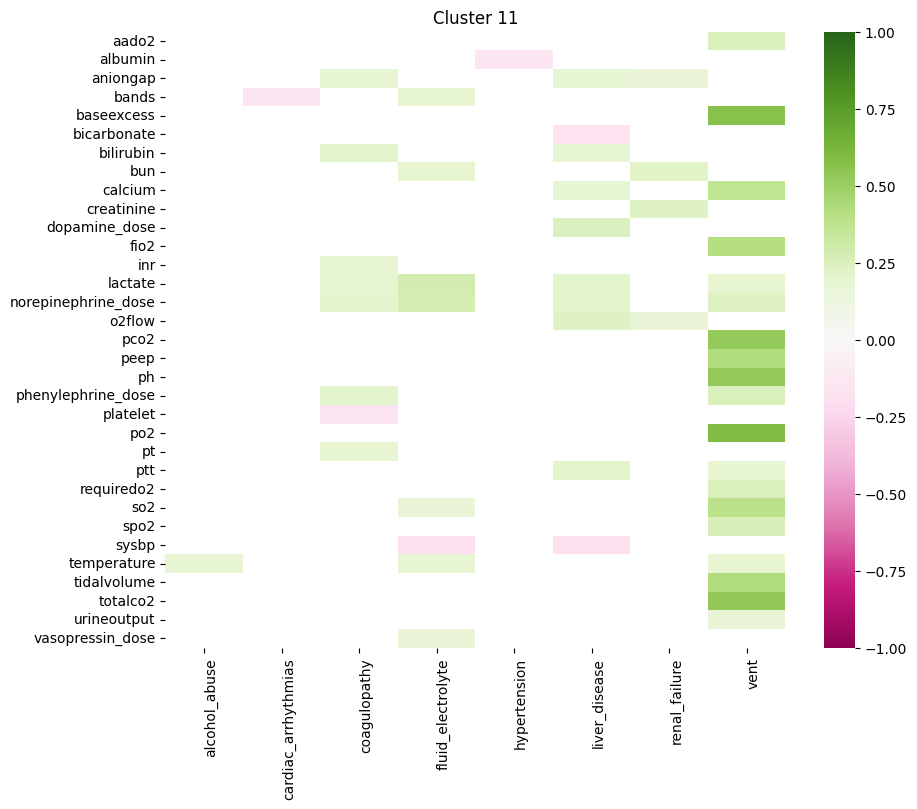

In [92]:
temp_static = static.join(hd_labels)
temp_static = temp_static[['vent', 'F', 'M', 'adults', 'seniors', 'race_white', 'gcs_13_15',
       'gcs_9_12', 'gcs_<8', 'congestive_heart_failure', 'cardiac_arrhythmias',
       'hypertension', 'other_neurological', 'chronic_pulmonary',
       'hypothyroidism', 'renal_failure', 'liver_disease', 'coagulopathy',
       'fluid_electrolyte', 'alcohol_abuse', 'depression', 'diabetes', 'mm_Agglomerative']]
temp_time = time_series_2d_df.join(hd_labels)
result = clustering_helpers.calculate_cluster_correlation_real_binary(temp_time, temp_static, labels_[0])
significant_result =  clustering_helpers.plot_correlation_heatmap(result[result[labels_[0]].isin([11])], correlation_threshold=0.1, pvalue_threshold=0.01, cluster=labels_[0],heatmap_all = False)

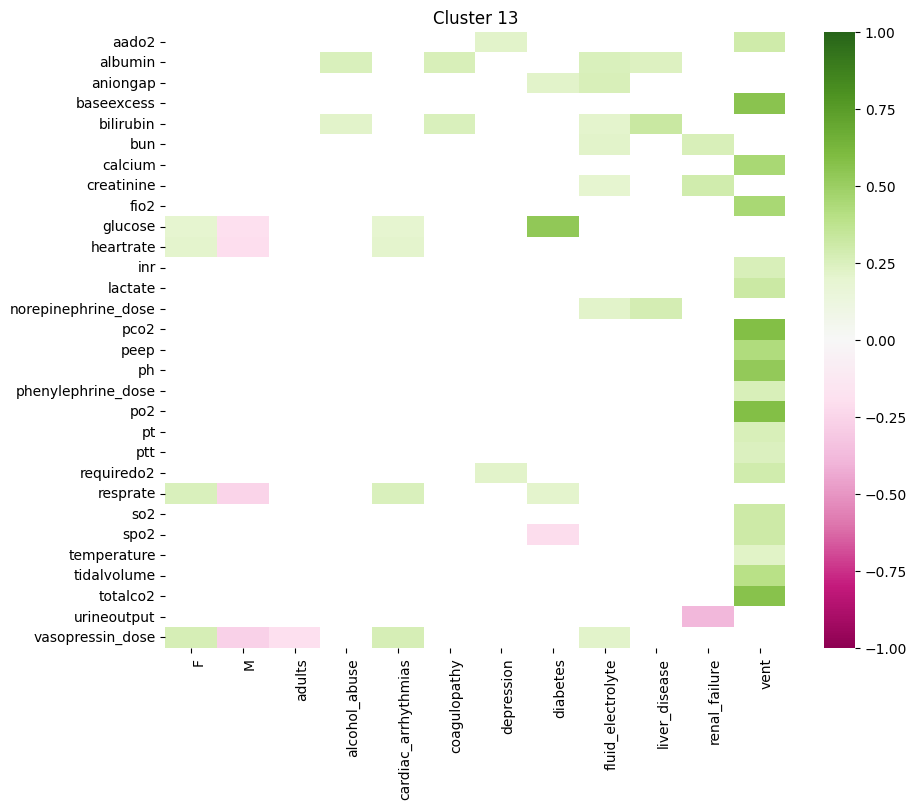

In [93]:
significant_result =  clustering_helpers.plot_correlation_heatmap(result[result[labels_[0]].isin([13])], correlation_threshold=0.1, pvalue_threshold=0.01, cluster=labels_[0],heatmap_all = False)

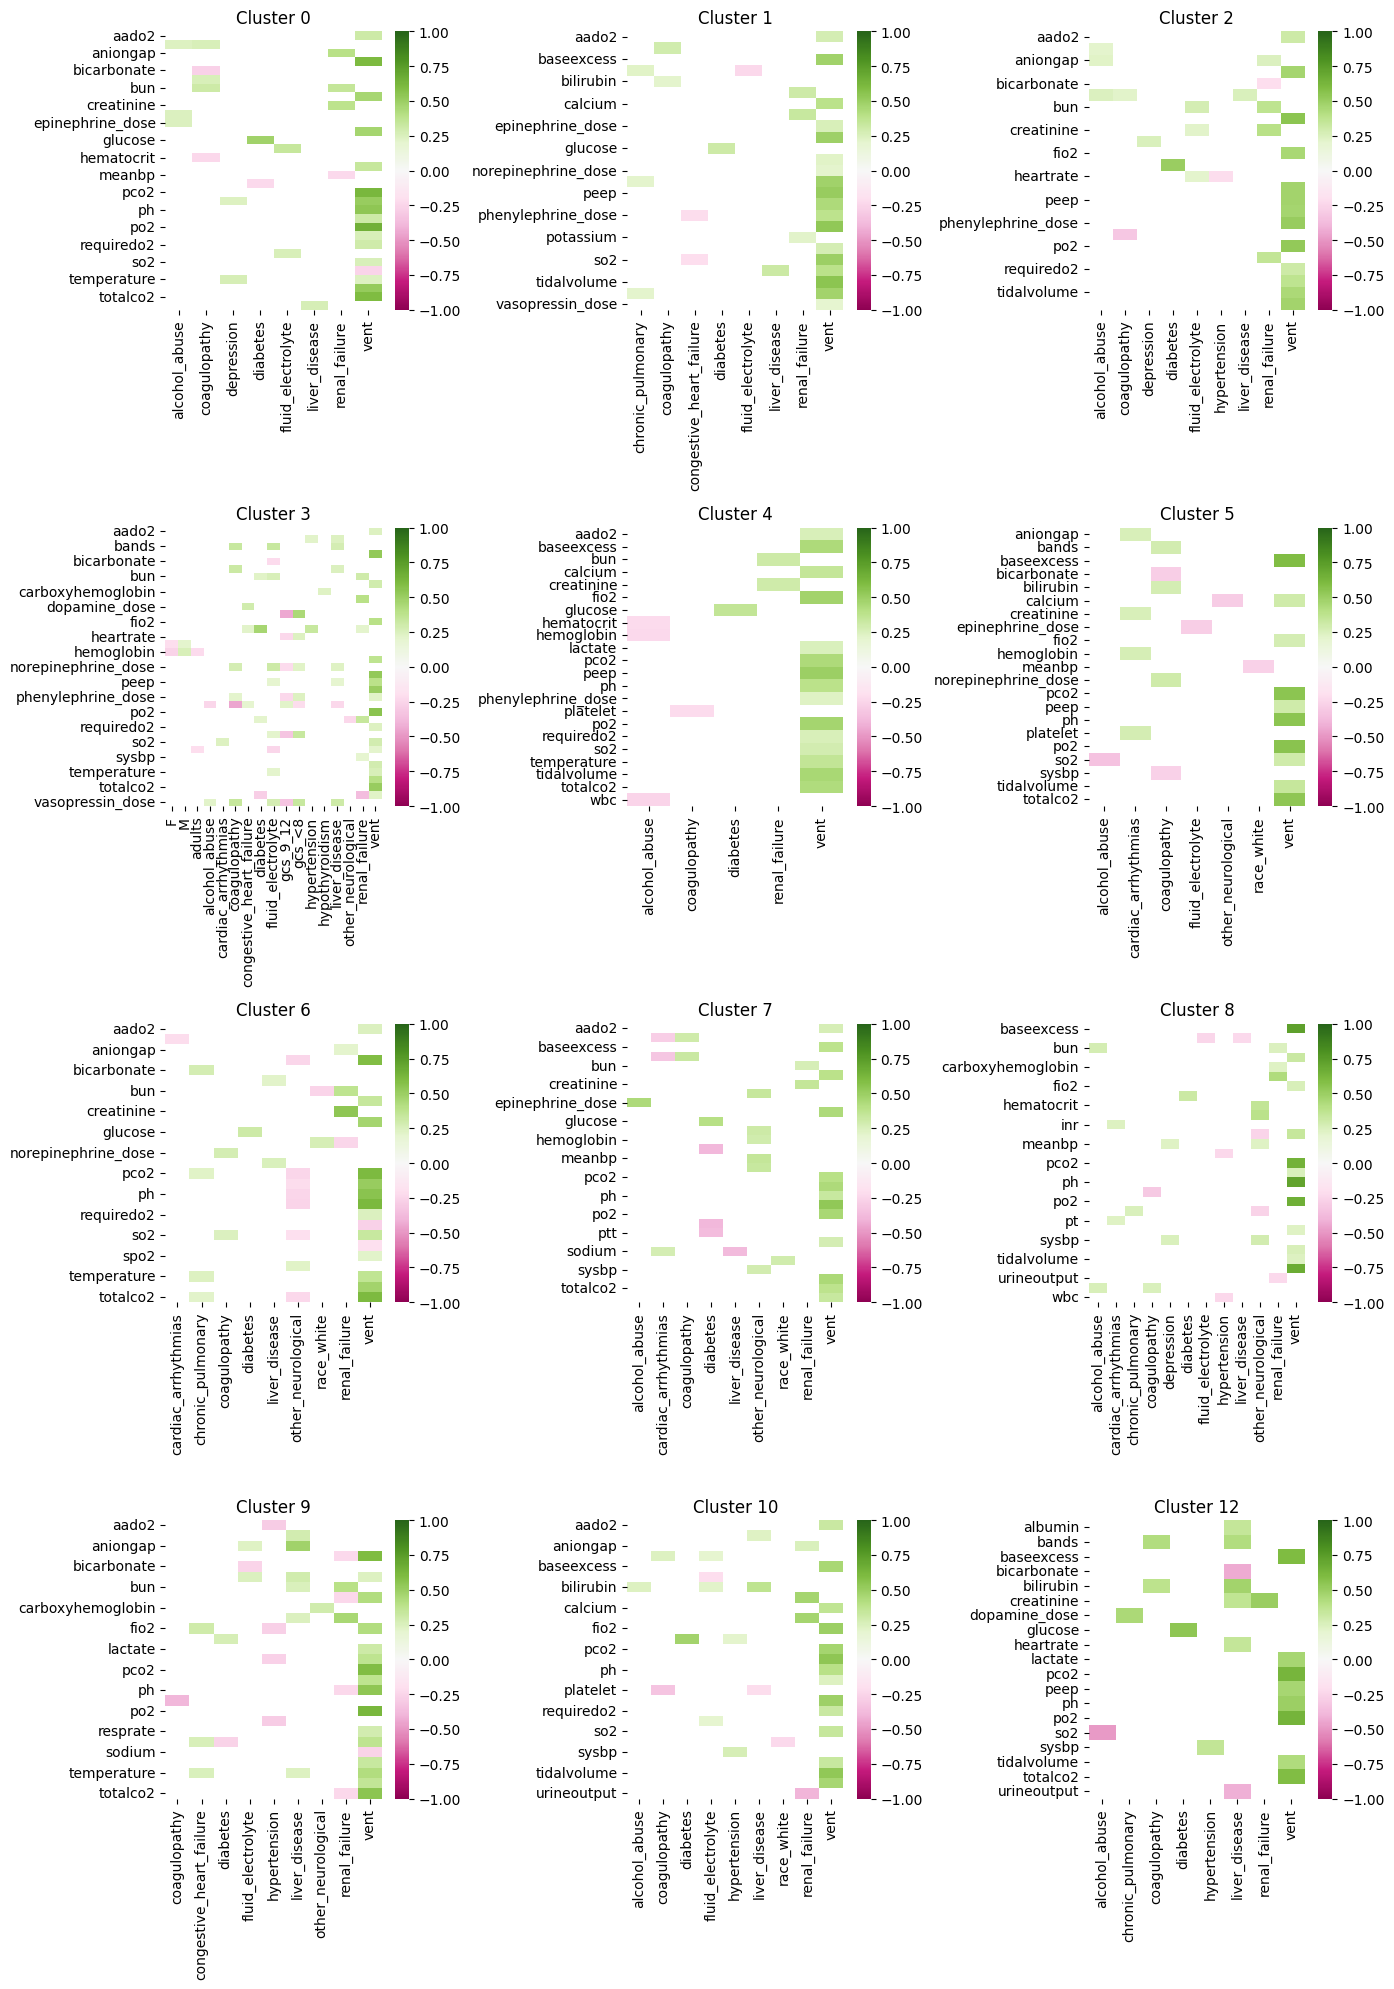

In [94]:

result = result.sort_values(by=labels_[0])
#7,8,9,10,12,14,15

significant_result =   clustering_helpers.plot_correlation_heatmap(result[result[labels_[0]].isin([0,1,2,3,4,5,6,7,8,9,10,12])], correlation_threshold=0.2, pvalue_threshold=0.01, cluster=labels_[0],heatmap_all = True)

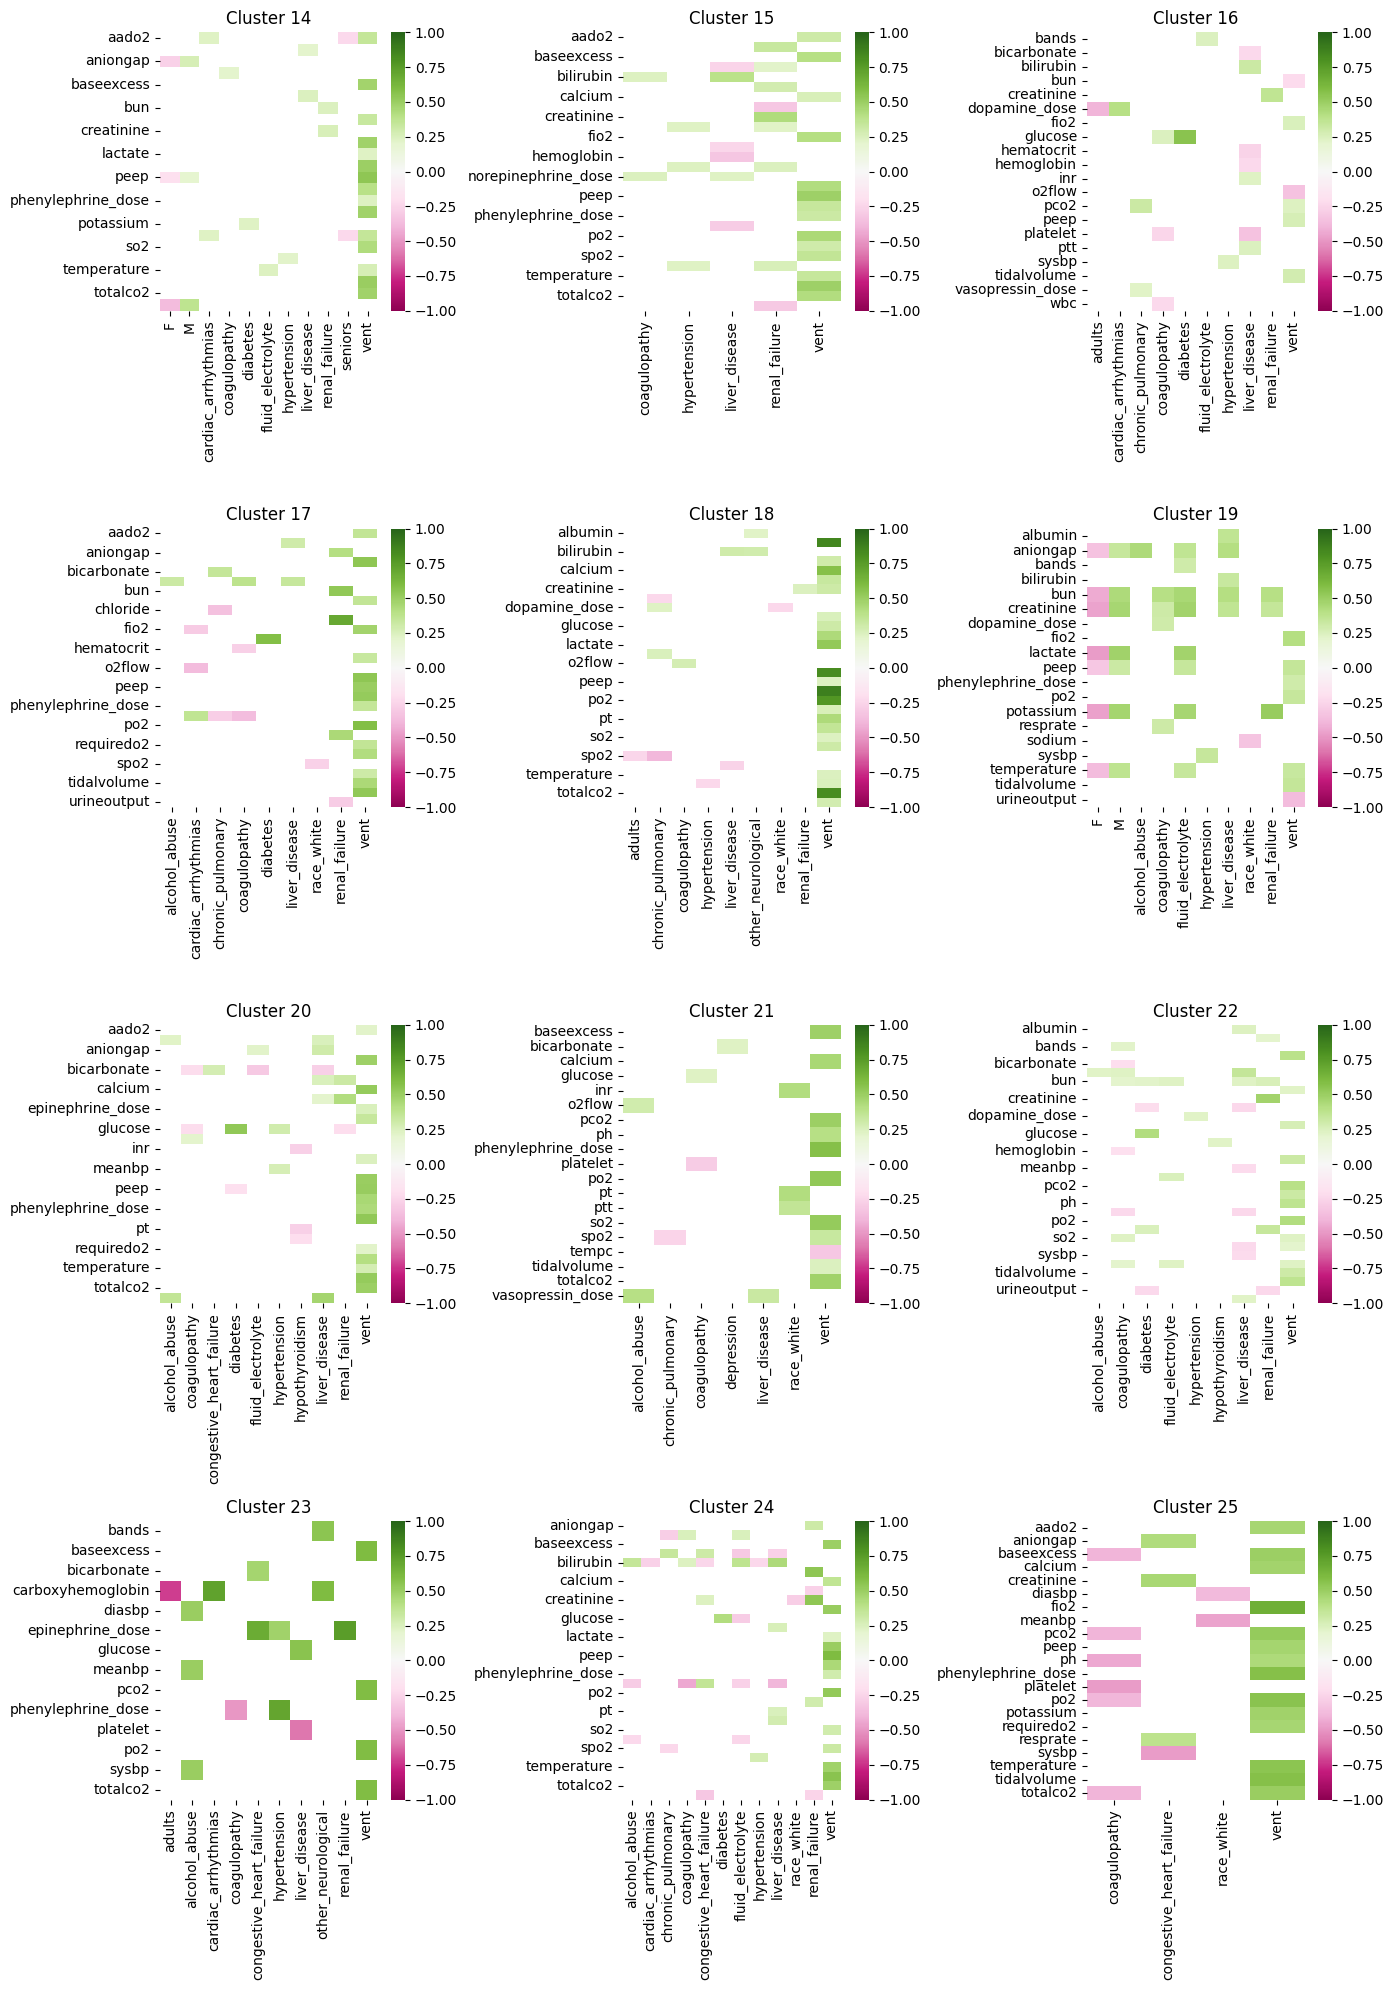

In [95]:
significant_result =   clustering_helpers.plot_correlation_heatmap(result[result[labels_[0]].isin([14, 15,16,17,18,19,20,21,22,23,24,25])], correlation_threshold=0.2, pvalue_threshold=0.01, cluster=labels_[0],  heatmap_all = True)

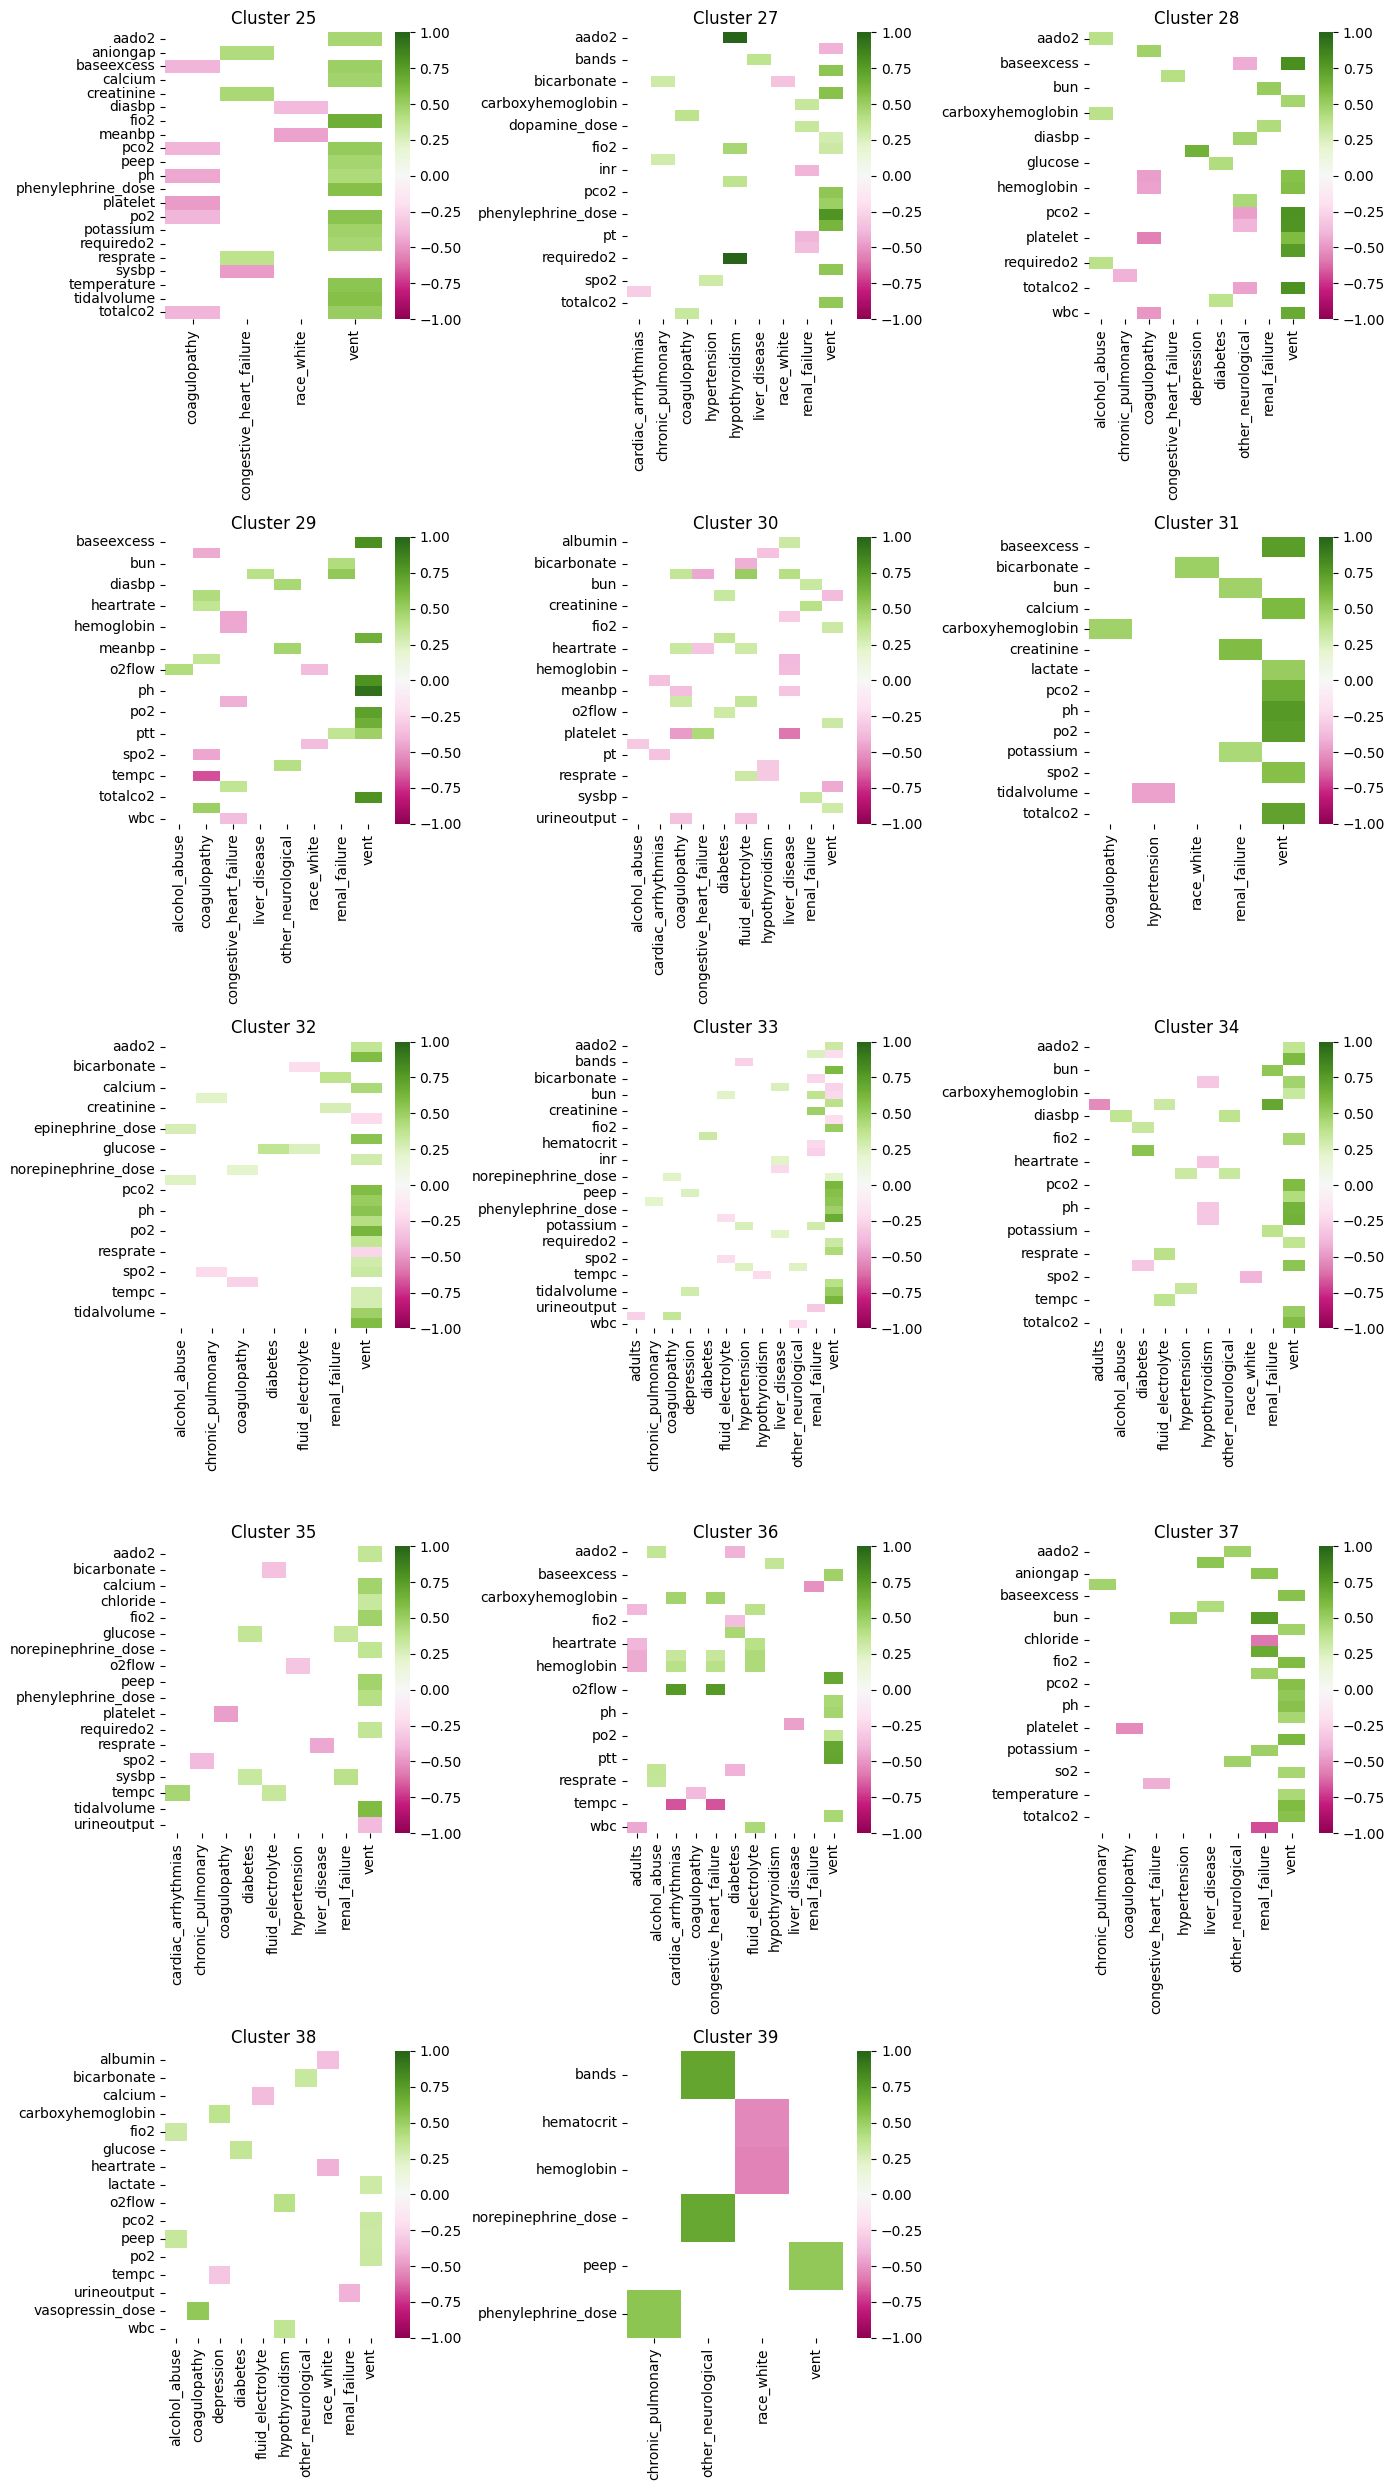

In [96]:
significant_result =   clustering_helpers.plot_correlation_heatmap(result[result[labels_[0]].isin([25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40])]\
                                                                   , correlation_threshold=0.2, pvalue_threshold=0.01, cluster=labels_[0],  heatmap_all = True)

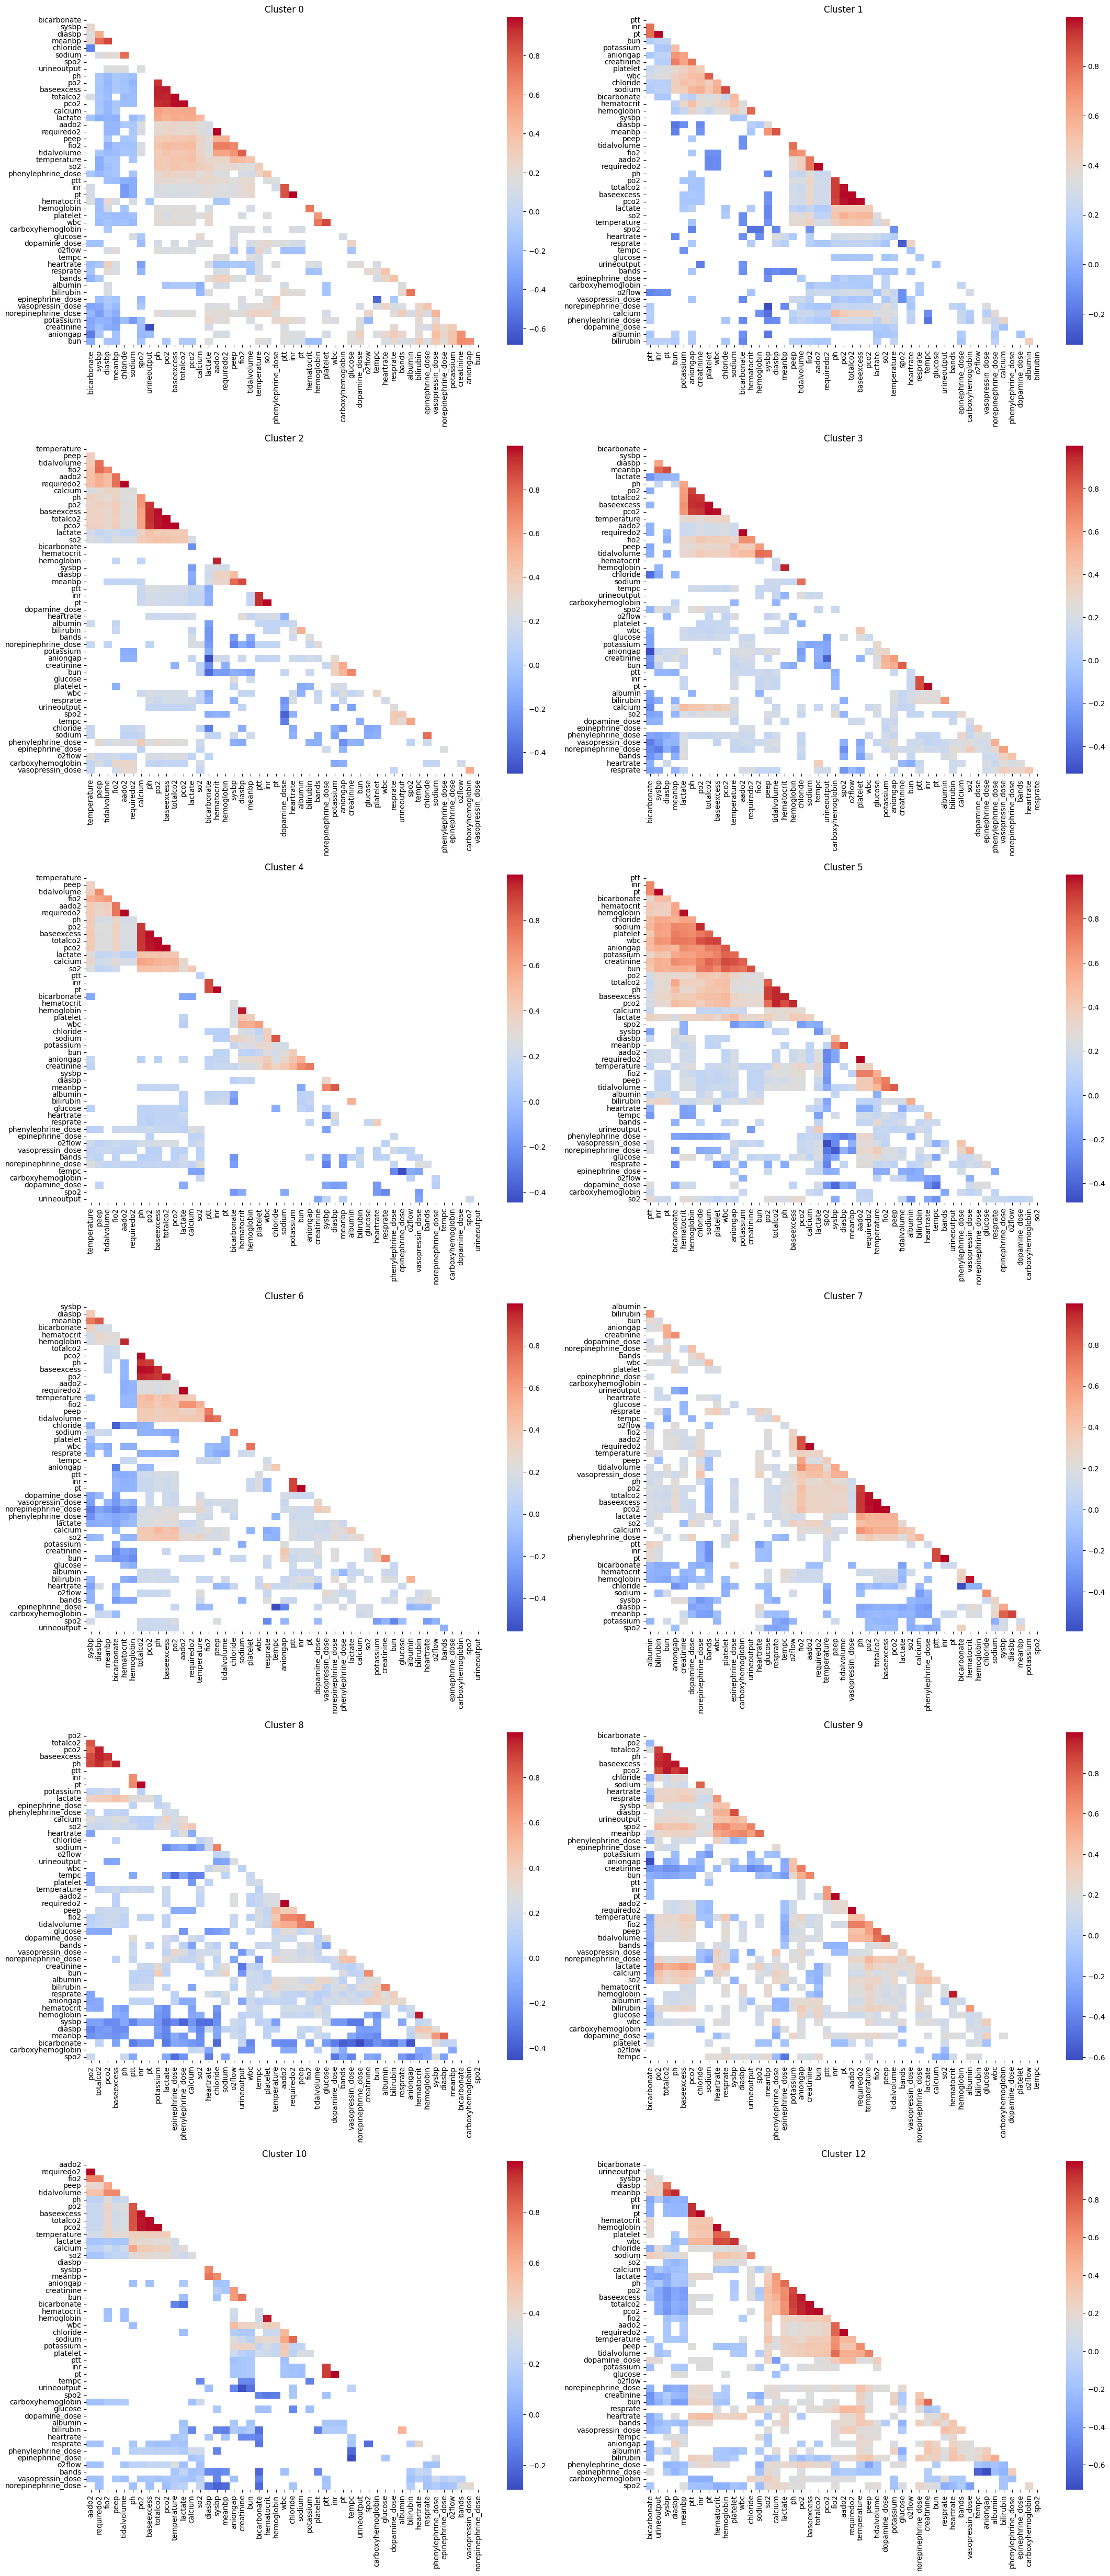

In [97]:
significant_correlations = clustering_helpers.plot_real_feature_correlation_per_cluster(temp_time[temp_time[labels_[0]].isin([0,1,2,3,4,5,6,7,8,9,10,12,])], cluster_column=labels_[0], cluster_to_plot=None, correlation_threshold=0.1, pvalue_threshold=0.05, heatmap=True)


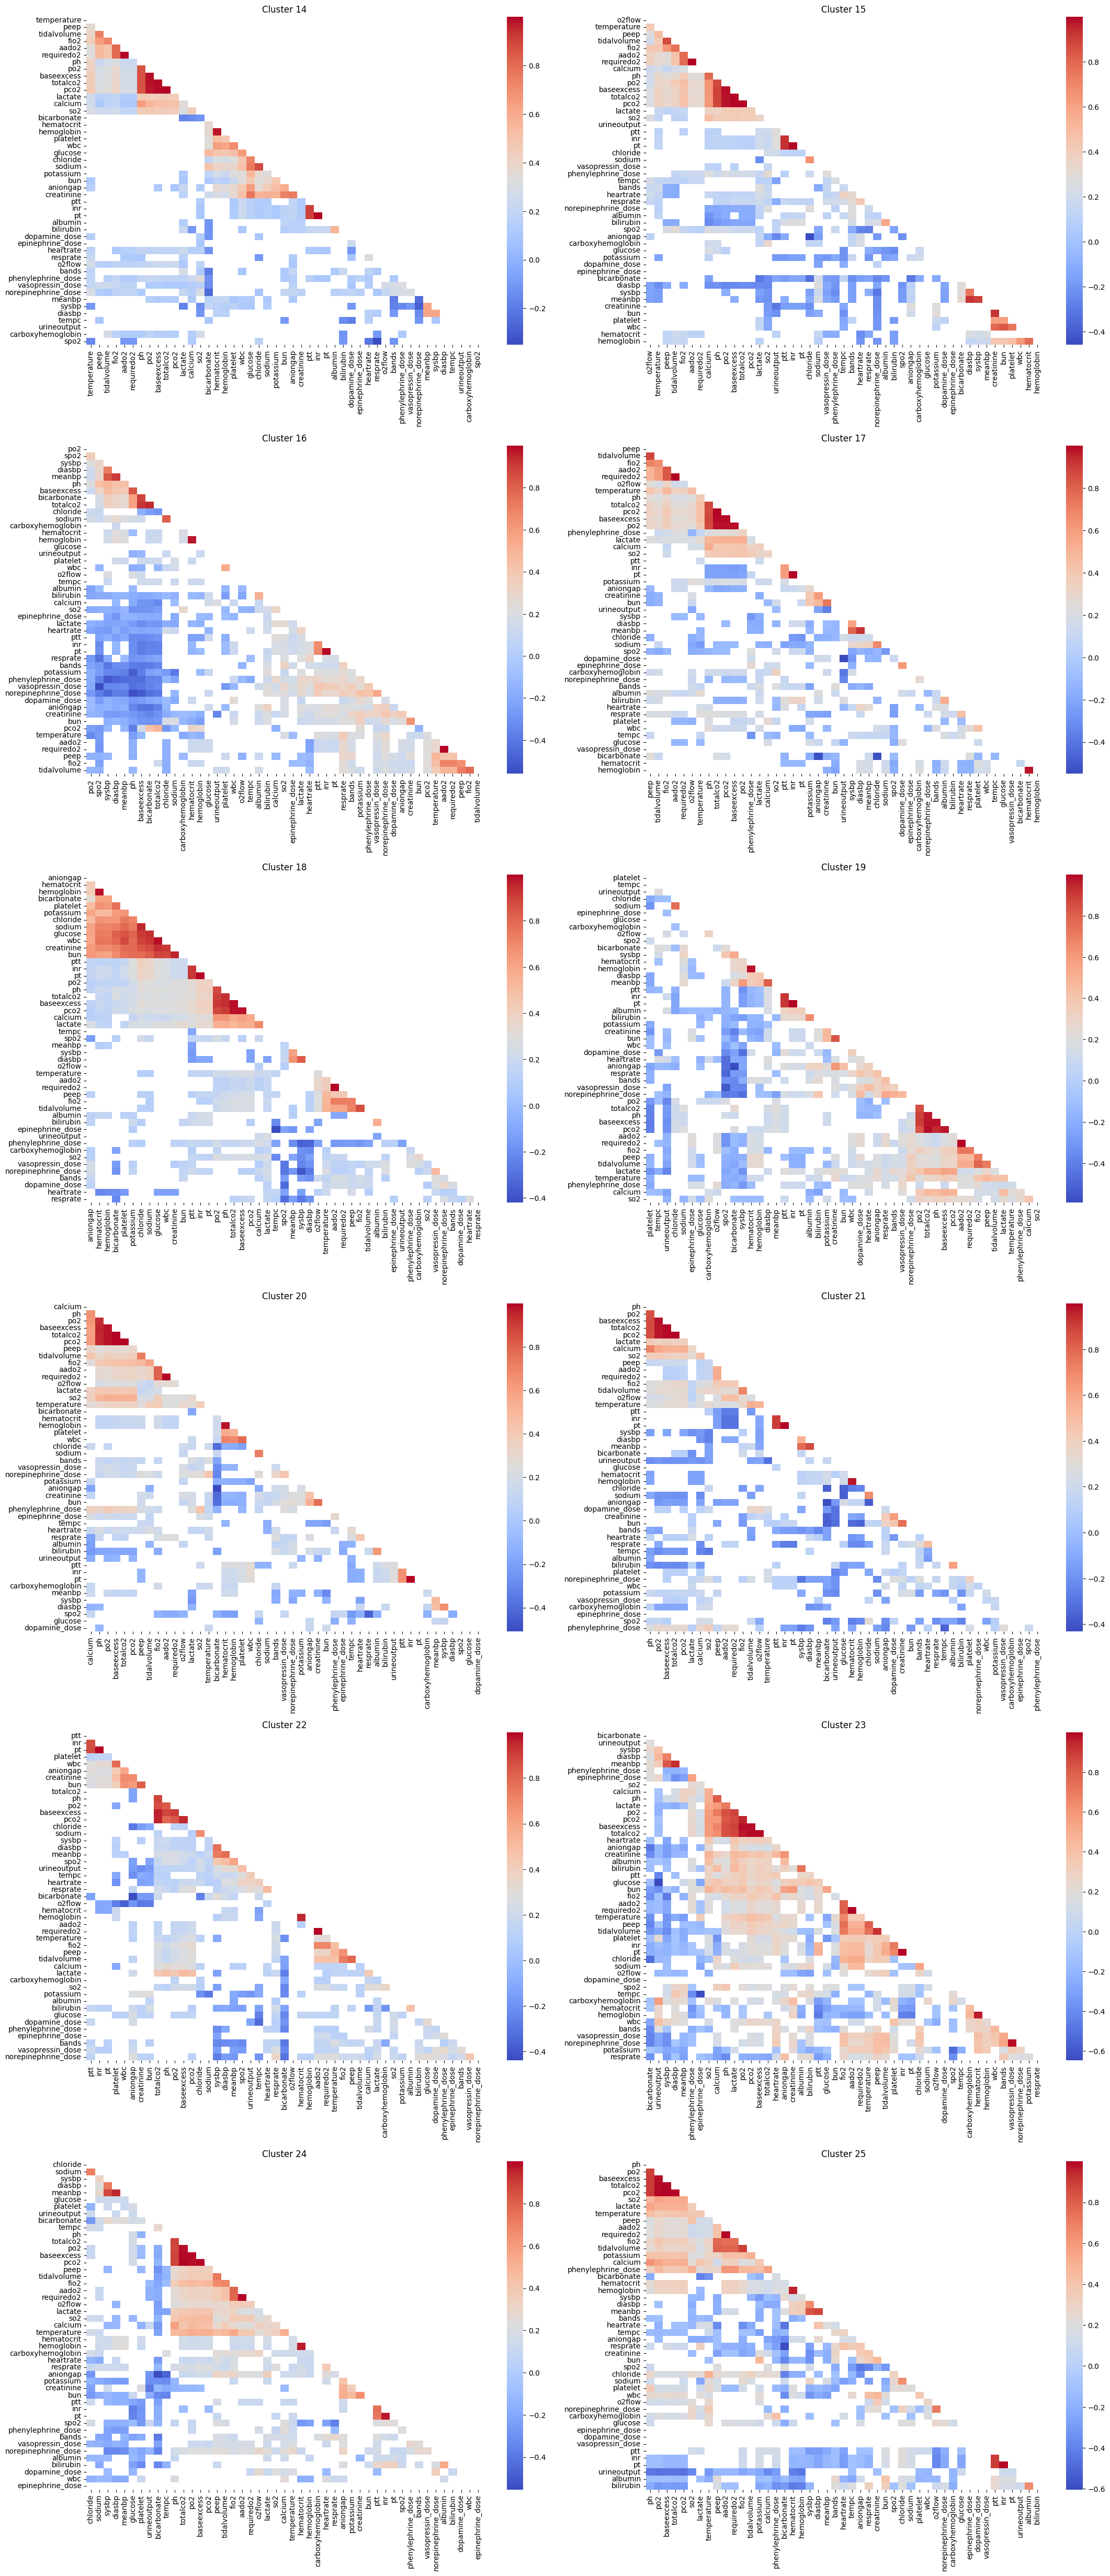

In [98]:


significant_correlations = clustering_helpers.plot_real_feature_correlation_per_cluster(temp_time[temp_time[labels_[0]].isin([14,15, 16,17,18,19,20,21,22,23,24,25])], cluster_column=labels_[0], cluster_to_plot=None, correlation_threshold=0.1, pvalue_threshold=0.05, heatmap=True)


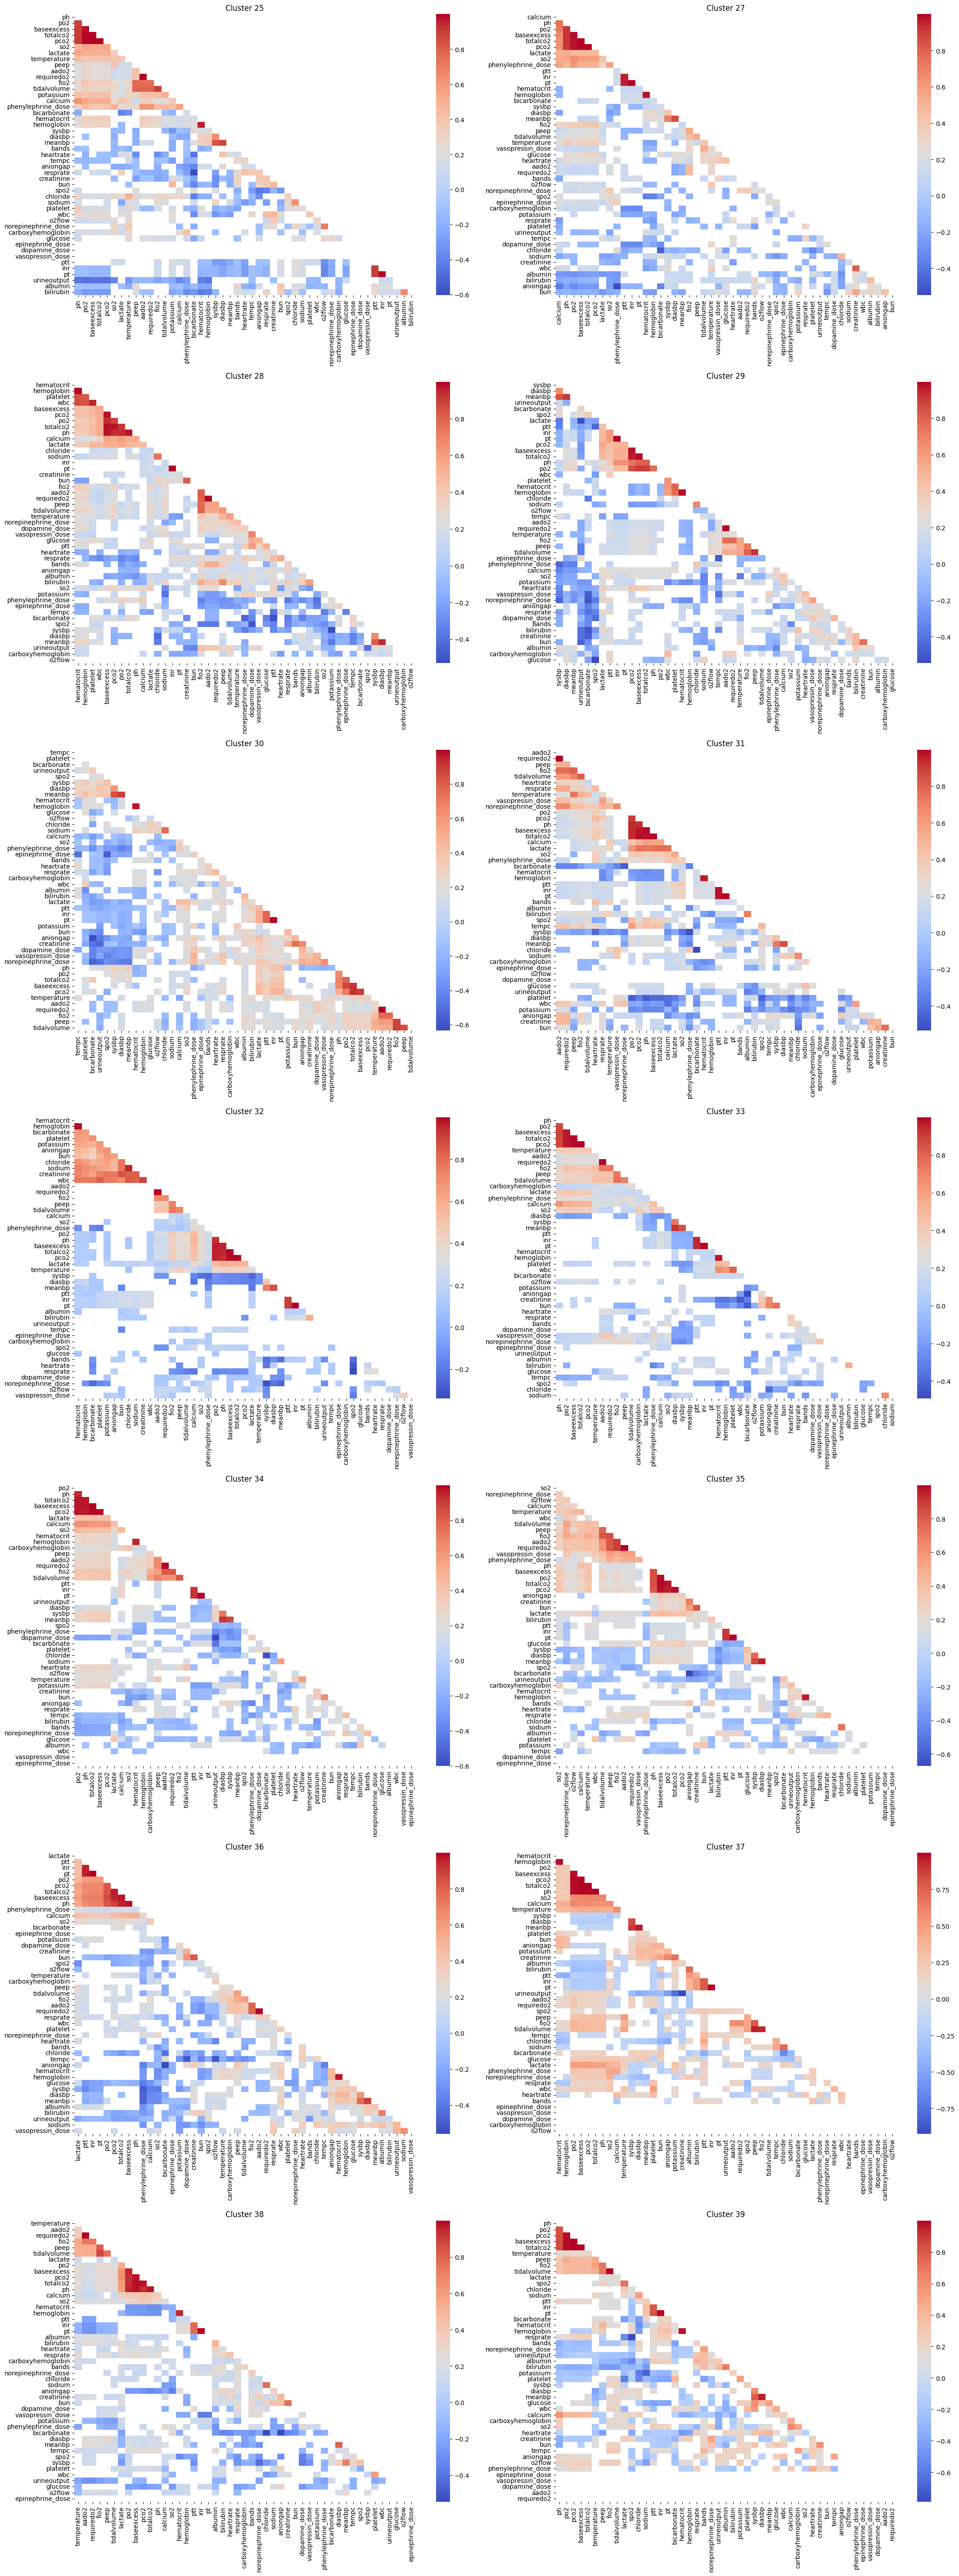

In [99]:
significant_correlations = clustering_helpers.plot_real_feature_correlation_per_cluster(temp_time[temp_time[labels_[0]].isin([25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40])], cluster_column=labels_[0], cluster_to_plot=None, correlation_threshold=0.1, pvalue_threshold=0.05, heatmap=True)


### Compare sepsis3 and angus 

In [100]:
path = f'results_EQ_angus' 
time_series_2d_angus = np.load('preprocessing/representations/time_series_2d_scaled_angus.npy')
time_series_3d_angus = np.load('preprocessing/representations/time_series_3d_scaled_angus.npy')

static_angus = pd.read_csv('preprocessing/representations/static_eq_angus.csv')
time_series_2d_df_angus = pd.read_csv('preprocessing/representations/time_series_2d_scaled_df_angus.csv')
all_labels_angus = pd.read_csv(f'{path}/metrics/all_labels.csv')

static_angus = static_angus.loc[:, static_angus.gt(0).mean() >= .1]

static_angus = static_angus.set_index('icustay_id')
all_labels_angus = all_labels_angus.set_index('icustay_id')

#angus
static_angus = static_angus[['vent', 'F', 'M', 'adults', 'seniors', 'race_white', 'gcs_13_15',
       'gcs_9_12', 'gcs_<8', 'congestive_heart_failure', 'cardiac_arrhythmias',
       'hypertension', 'other_neurological', 'chronic_pulmonary',
       'hypothyroidism', 'renal_failure',
       'liver_disease', 'coagulopathy', 'fluid_electrolyte', 'alcohol_abuse',
       'depression', 'diabetes', 'circulatory',
       'circulatory_infectious_congenital', 'nervous_and_sense',
       'endocrinal_nutritional', 'neoplasms', 'blood_and_blood_forming',
       'mental']]
path = f'results_EQ_angus/saved_models' 
latent_ts_angus, latent_st_angus, latent_mm_angus = helpers.load_encoded_spaces(time_series_3d_angus, static_angus, 'latent_4(5)_EQ', path)


90/90 [==============================] - 0s 2ms/step
STATIC AE SHAPE: (2867, 4)
90/90 [==============================] - 2s 7ms/step
GRU SHAPE: (2867, 8)
90/90 [==============================] - 2s 7ms/step
MM SHAPE: (2867, 10)


In [101]:
from scipy.optimize import linear_sum_assignment

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import TSNE

def match_labels(labels1, labels2):
    """
    Match cluster labels between two runs using the Hungarian algorithm.

    Parameters:
        labels1 (numpy array): Cluster labels from the first run.
        labels2 (numpy array): Cluster labels from the second run.

    Returns:
        numpy array: Cluster labels from the second run, aligned with the first run.
    """

    num_labels1 = np.max(labels1) + 1
    num_labels2 = np.max(labels2) + 1

    label_overlap = np.zeros((num_labels1, num_labels2), dtype=int)

    for i in range(num_labels1):
        for j in range(num_labels2):
            label_overlap[i, j] = np.sum((labels1 == i) & (labels2 == j))

    row_ind, col_ind = linear_sum_assignment(-label_overlap)

    aligned_labels2 = np.zeros_like(labels2)
    for i, j in zip(row_ind, col_ind):
        aligned_labels2[labels2 == j] = i

    return aligned_labels2



def get_matching_clusters(cohort1_results, cohort2_results, cohort1_dataframe, cohort2_dataframe):
    # Find common samples
    common_samples = cohort1_dataframe.index.intersection(cohort2_dataframe.index)

    if not common_samples.any():
        raise ValueError("No common samples found.")

    # Extract cluster assignments for common samples
    clusters1 = cohort1_results.loc[common_samples].values
    clusters2 = cohort2_results.loc[common_samples].values

    # Match cluster labels using the provided function
    matched_clusters2 = match_labels(clusters1, clusters2)

    # Compare cluster assignments
    ari_score = adjusted_rand_score(clusters1, matched_clusters2)
    
    # import matplotlib.pyplot as plt
    # from sklearn.manifold import TSNE

    # # Visualize the matched clusters using t-SNE
    # tsne = TSNE(n_components=2, random_state=42)
    # embedding = tsne.fit_transform(cohort1_dataframe.loc[matching_patients].values)

    # plt.figure(figsize=(20, 20))


    # plt.scatter(embedding[:, 0], embedding[:, 1], c=clusters1, cmap='viridis', label='Cohort 1 Clusters')
    # plt.scatter(embedding[:, 0], embedding[:, 1], c=matched_clusters2, cmap='plasma', marker='x', label='Matched Cohort 2 Clusters')
    # plt.title(f'Adjusted Rand Index: {ari_score:.2f}')
    # plt.legend()
    # plt.show()

    return ari_score, common_samples, matched_clusters2

# Continue from the previous example
cohort1_ids = list(static.index)
cohort2_ids = list(static_angus.index)
dataframe_1 = pd.DataFrame(latent_mm, index=cohort1_ids)

dataframe_2 = pd.DataFrame(latent_mm_angus, index=cohort2_ids)

ari_score, matching_patients, matching_clusters = get_matching_clusters(all_labels['mm_Agglomerative'], all_labels_angus['mm_Agglomerative'], dataframe_1, dataframe_2)

print(f"Adjusted Rand Index: {ari_score:.2f}")
print("Matching Patients:", list(matching_patients))
print("Matching Clusters:", list(matching_clusters))


Adjusted Rand Index: 0.57
Matching Patients: [200075, 200087, 200131, 200143, 200172, 200231, 200234, 200349, 200441, 200453, 200463, 200616, 200636, 200708, 200724, 200773, 200916, 200946, 200994, 201027, 201029, 201046, 201077, 201092, 201098, 201151, 201215, 201220, 201358, 201360, 201370, 201401, 201457, 201525, 201598, 201605, 201612, 201659, 201715, 201742, 201850, 201857, 201868, 201920, 201924, 201959, 201979, 202030, 202089, 202115, 202134, 202142, 202182, 202242, 202381, 202438, 202476, 202499, 202506, 202629, 202635, 202639, 202652, 202837, 202890, 202907, 202919, 202932, 202941, 202945, 202981, 202990, 203031, 203052, 203105, 203111, 203169, 203186, 203194, 203256, 203290, 203308, 203362, 203364, 203453, 203460, 203471, 203543, 203550, 203626, 203630, 203664, 203674, 203679, 203782, 203784, 203815, 203880, 203888, 203911, 203979, 204061, 204145, 204176, 204194, 204236, 204248, 204305, 204505, 204522, 204536, 204538, 204602, 204603, 204615, 204619, 204632, 204686, 204690, 20

In [102]:
set(matching_clusters)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 20,
 22,
 24,
 26,
 32,
 33,
 38}

In [103]:
def assess_clustering_similarity(cohort1_results, cohort2_results, cohort1_dataframe, cohort2_dataframe, match_labels, similarity_threshold=0.5):
    # Get matching clusters and ARI
    ari_score, matching_patients, matched_clusters = get_matching_clusters(
        cohort1_results, cohort2_results, cohort1_dataframe, cohort2_dataframe
    )
    cohort2 = pd.DataFrame(matched_clusters, index=cohort2_results.index)
    print(cohort1_results)

    # Calculate the percentage of common patients
    percentage_common_patients = len(matching_patients) / len(cohort1_dataframe) * 100

    print(f"Adjusted Rand Index: {ari_score:.2f}")
    print(f"Percentage of Common Patients: {percentage_common_patients:.2f}%")

    # Identify clusters with agreement above the similarity threshold
    for cluster_id in np.unique(cohort1_results):
        cluster1_indices = cohort1_results.index[cohort1_results == cluster_id]
        cluster2_indices = matched_clusters == cluster_id

        common_indices = np.intersect1d(cluster1_indices, matching_patients)

        similarity_percentage = len(common_indices) / len(cluster1_indices) * 100

        if similarity_percentage >= similarity_threshold:
            print(f"\nCluster {cluster_id} Agreement: {similarity_percentage:.2f}%")
            print(f"\nCluster {cluster_id} Agreement Length: {len(common_indices)}")
            print(f"Cluster1 Length: {len(cohort1_results[cohort1_results == cluster_id])}")
            print(f"Cluster2 Length: {len(cohort2[cohort2 == cluster_id])}")
            print("Common Patients:")
            print(common_indices)


assess_clustering_similarity(all_labels['mm_Agglomerative'], all_labels_angus['mm_Agglomerative'], dataframe_1, dataframe_2, match_labels)


icustay_id
200061    33
200075     4
200087    20
200116    24
200131    32
200135    14
200143    10
200169    33
200172    35
200191    36
200208     3
200217    14
200225    27
200231    14
200234    14
200240     5
200286    11
200349     6
200357     4
200439     4
200441    27
200450     4
200453    36
200463     2
200526     8
200530    32
200544     3
200575     1
200586     6
200616    14
200625    10
200636     1
200708    10
200711     3
200724    35
200729    25
200758     4
200773     2
200824    32
200827    21
200873    33
200913    20
200916    10
200917    32
200935     4
200944    33
200946     1
200977    17
200994     8
201004    10
201018     7
201027    10
201029    10
201045    20
201046     9
201077    16
201089    38
201092     4
201098    30
201125     4
201151    14
201193     4
201214    26
201215     2
201220    16
201245     1
201358    12
201360    18
201368    15
201370    14
201372    14
201401    33
201422    22
201437     2
201457     1
201525     9
2